In [ ]:
import pandas as pd

# 1️⃣ Load file
df = pd.read_csv("emotion_output_ekman_predicted.csv")

# 2️⃣ Define Ekman emotion probability columns
ekman_cols = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

# 3️⃣ Confirm columns exist
for col in ekman_cols:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in the file!")

# 4️⃣ Function to get top 3 emotions
def top3(row):
    sorted_emotions = row[ekman_cols].sort_values(ascending=False)
    return list(sorted_emotions.index[:3])

# 5️⃣ Apply the function to create new column
df["top_3_ekman"] = df[ekman_cols].apply(top3, axis=1)

# 6️⃣ Convert list to a clean string 
df["top_3_ekman"] = df["top_3_ekman"].apply(lambda lst: ", ".join(lst))

# 7️⃣ Save new file
output_path = "emotion_output_ekman_predicted_top3.csv"
df.to_csv(output_path, index=False)

print(f"✅ New file created and saved as: {output_path}")
print("Example rows:\n", df[["predicted_emotion", "top_3_ekman"]].head())


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/1450171133.py:4: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



✅ New file created and saved as: emotion_output_ekman_predicted_top3.csv
Example rows:
   predicted_emotion              top_3_ekman
0           sadness   sadness, fear, neutral
1           sadness  sadness, anger, neutral
2          surprise  surprise, sadness, fear
3             anger     anger, fear, sadness
4           sadness   sadness, fear, neutral


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/2528712284.py:8: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



✅ Graph built: 7 emotions, 21 edges


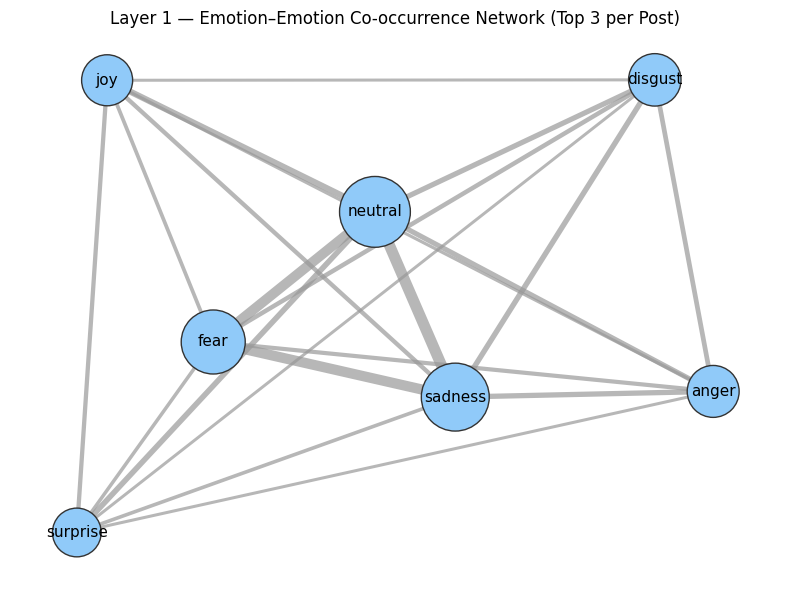


🔹 Top connected emotions (by weighted degree):
  neutral    → 68256.0
  sadness    → 60346.0
  fear       → 50232.0
  disgust    → 23718.0
  anger      → 22666.0
  joy        → 20820.0
  surprise   → 16360.0

🔹 Bridge emotions (betweenness centrality):
  surprise   → 0.600
  anger      → 0.267
  disgust    → 0.133
  sadness    → 0.000
  neutral    → 0.000
  fear       → 0.000
  joy        → 0.000

🔹 Influential emotions (eigenvector centrality):
  neutral    → 0.556
  sadness    → 0.541
  fear       → 0.492
  disgust    → 0.225
  anger      → 0.212
  joy        → 0.196
  surprise   → 0.151


In [ ]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# 1️⃣ Load new file
df = pd.read_csv("emotion_output_ekman_predicted_top3.csv")

# 2️⃣ Ensure column exists and parse top_3_ekman into lists
if "top_3_ekman" not in df.columns:
    raise ValueError("Column 'top_3_ekman' not found in CSV!")

df["top_3_ekman"] = df["top_3_ekman"].apply(lambda x: [e.strip() for e in str(x).split(",")])

# 3️⃣ Count emotion co-occurrences
pair_counter = Counter()
single_counter = Counter()

for emos in df["top_3_ekman"]:
    unique_emos = list(set(emos))  # avoid double counting same emotion
    for e in unique_emos:
        single_counter[e] += 1
    for a, b in itertools.combinations(sorted(unique_emos), 2):
        pair_counter[(a, b)] += 1

# 4️⃣ Build NetworkX graph
G = nx.Graph()
for e, c in single_counter.items():
    G.add_node(e, count=c)
for (a, b), w in pair_counter.items():
    G.add_edge(a, b, weight=w)

print(f"✅ Graph built: {len(G.nodes())} emotions, {len(G.edges())} edges")

# 5️⃣ Compute basic metrics
degw = dict(G.degree(weight="weight"))
betw = nx.betweenness_centrality(G, weight="weight", normalized=True)
eig  = nx.eigenvector_centrality_numpy(G, weight="weight") if G.number_of_edges()>0 else {n:0 for n in G.nodes()}

# 6️⃣ Visualise
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42, weight="weight", k=0.5)
sizes = [800 + 1800*(degw[n]/max(degw.values())) for n in G.nodes()]
widths = [2 + 6*(d["weight"]/max(w["weight"] for _,_,w in G.edges(data=True))) for _,_,d in G.edges(data=True)]

nx.draw_networkx_edges(G, pos, width=widths, edge_color="#999", alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="#90caf9", edgecolors="#333")
nx.draw_networkx_labels(G, pos, font_size=11)
plt.title("Layer 1 — Emotion–Emotion Co-occurrence Network (Top 3 per Post)")
plt.axis("off"); plt.tight_layout(); plt.show()

# 7️⃣ Quick textual insights
print("\n🔹 Top connected emotions (by weighted degree):")
for e, d in sorted(degw.items(), key=lambda x: x[1], reverse=True):
    print(f"  {e:10s} → {d:.1f}")

print("\n🔹 Bridge emotions (betweenness centrality):")
for e, b in sorted(betw.items(), key=lambda x: x[1], reverse=True):
    print(f"  {e:10s} → {b:.3f}")

print("\n🔹 Influential emotions (eigenvector centrality):")
for e, val in sorted(eig.items(), key=lambda x: x[1], reverse=True):
    print(f"  {e:10s} → {val:.3f}")


In [ ]:
import pandas as pd
import re

# ---------------- CONFIG ----------------
CSV = "emotion_output_ekman_predicted.csv"
OUTPUT = "emotion_output_ekman_predicted_tokenized.csv"

STOPWORDS = {
    "the","and","to","of","a","in","i","it","is","you","for","on","that","this","with",
    "me","my","im","was","but","have","so","they","be","are","at","we","not","just",
    "do","if","its","what","your","from","as","or","an","by","like","about","had",
    "been","out","up","when","how","there","one","were","can","all","get","did",
    "because","into","more","also","than","any","would","even","really","dont","cant",
    "could","should","will","didnt","does","them","their","these","those","too","very",
    "u","us","got","know","see","much","ever","something","some","make","made","going"
}

df = pd.read_csv(CSV)

TEXT_CANDIDATES = ["clean_text","proc_text","text","raw_text","selftext","content","post","body","title"]
text_col = next((c for c in TEXT_CANDIDATES if c in df.columns), None)
if text_col is None:
    raise ValueError(f"No text column found among {TEXT_CANDIDATES}")

print(f"🟩 Using text column: {text_col}")

#  TOKENIZATION FUNCTION 
token_re = re.compile(r"[a-z]+(?:'[a-z]+)?")

def tokenize(text):
    if pd.isna(text): 
        return ""
    tokens = [
        t for t in token_re.findall(str(text).lower())
        if len(t) > 2 and t not in STOPWORDS
    ]
    return " ".join(tokens)  # space-joined for readability

#  APPLY TOKENIZATION 
df["tokenized_text"] = df[text_col].apply(tokenize)

#  SAVE 
df.to_csv(OUTPUT, index=False)
print(f"✅ Tokenized text column added and saved to: {OUTPUT}")
print(df[["tokenized_text"]].head(10))


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/1749603617.py:20: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



🟩 Using text column: clean_text
✅ Tokenized text column added and saved to: emotion_output_ekman_predicted_tokenized.csv
                                      tokenized_text
0  depressed after drinking alcohol feel fraud po...
1  smart chronic depression dpdr loves everyone h...
2  laziness stuff brushing teeth showering strugg...
3  stressed tired existing first off suicidal don...
4  think might depressed feel life good female tu...
5  masking called friend today which rarely said ...
6  girlfriend called girlfriend told she wishes k...
7  need support depressed lonely haven proper fri...
8  need help don wrong anymore falling back old h...
9  started wellbutrin looking others experiences ...


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/3804876945.py:23: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



Emotions: 7, Unique words: 33


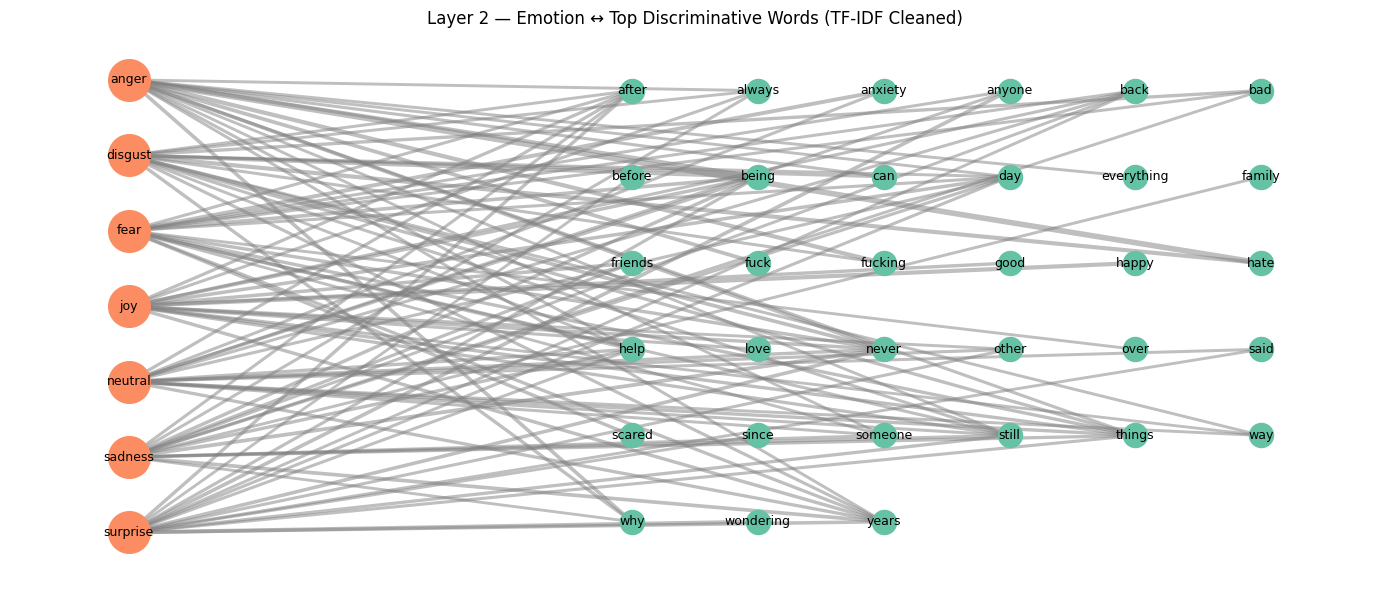


Top words per emotion:
  anger   : hate, fucking, being, fuck, why, never, things, help, can, years
  disgust : hate, being, never, why, things, bad, years, still, fucking, can
  fear    : anxiety, being, help, scared, never, things, years, still, after, day
  joy     : happy, being, friends, day, years, never, good, things, after, still
  neutral : being, never, things, help, years, after, other, day, anxiety, still
  sadness : never, years, being, help, things, friends, still, day, after, always
  surprise: wondering, anyone, never, years, after, still, being, things, day, other


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
-
CSV = "emotion_output_ekman_predicted_tokenized.csv"
EMOTIONS = ["anger","disgust","fear","joy","sadness","surprise","neutral"]
TOP_WORDS = 15  # top words per emotion

# Extra stopwords to clean generic or fragmented terms
CUSTOM_STOP = {
    "don","want","feel","ve","didn","ive","youre","gotta","wanna","myself","who","only","then",
    "people","time","life","know","think","get","like","she","her","him","has","now","it","his"
}

df = pd.read_csv(CSV)
for e in EMOTIONS:
    if e not in df.columns:
        raise ValueError(f"Missing emotion column: {e}")
if "tokenized_text" not in df.columns:
    raise ValueError("No 'tokenized_text' column found. Run tokenization first.")

df[EMOTIONS] = df[EMOTIONS].apply(pd.to_numeric, errors="coerce").fillna(0.0)

emo_docs = {}
for e in EMOTIONS:
    weights = df[e]
    scaled = (weights / weights.max() * 10).round().astype(int)
    corpus = []
    for text, rep in zip(df["tokenized_text"], scaled):
        if rep > 0 and isinstance(text, str):
            corpus += [text] * rep
    emo_docs[e] = " ".join(corpus)


vectorizer = TfidfVectorizer(
    max_features=3000,
    stop_words=list(CUSTOM_STOP.union({"english"}))
)
X = vectorizer.fit_transform([emo_docs[e] for e in EMOTIONS])
vocab = np.array(vectorizer.get_feature_names_out())


edges = []
for i, e in enumerate(EMOTIONS):
    row = X[i].toarray().ravel()
    top_idx = np.argsort(-row)[:TOP_WORDS]
    for j in top_idx:
        w = vocab[j]
        score = row[j]
        edges.append((e, w, score))

print(f"Emotions: {len(EMOTIONS)}, Unique words: {len(set(w for _,w,_ in edges))}")

# ---------------------------------------------------
# 6️⃣ Build Bipartite Graph (Left=Emotions, Right=Words)
# ---------------------------------------------------
B = nx.Graph()
emotions = sorted(set(e for e,_,_ in edges))
words = sorted(set(w for _,w,_ in edges))

B.add_nodes_from(emotions, bipartite=0)
B.add_nodes_from(words, bipartite=1)

for e, w, s in edges:
    B.add_edge(e, w, weight=s)

# ---------------------------------------------------
pos = {}
y_step = 1.0 / (len(emotions) + 1)
for i, e in enumerate(emotions):
    pos[e] = (-0.8, 1 - (i + 1) * y_step)

cols = 6
rows = (len(words) + cols - 1) // cols
x_positions = [0.2 + 0.25 * i for i in range(cols)]
y_positions = [1 - (r + 1) * (1.0 / (rows + 1)) for r in range(rows)]

for idx, w in enumerate(words):
    cx = idx % cols
    ry = idx // cols
    pos[w] = (x_positions[cx], y_positions[ry])


# ---------------------------------------------------
plt.figure(figsize=(14, max(6, 0.6 * len(emotions))))
emo_nodes = emotions
word_nodes = words

# Node colors
nx.draw_networkx_nodes(
    B, pos,
    nodelist=emo_nodes,
    node_color="#fc8d62",
    node_size=900,
    label="Emotions"
)
nx.draw_networkx_nodes(
    B, pos,
    nodelist=word_nodes,
    node_color="#66c2a5",
    node_size=300,
    label="Words"
)

# Edges scaled by TF-IDF weight
edge_weights = [d["weight"] for _, _, d in B.edges(data=True)]
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [1 + 3 * (w / max_w) for w in edge_weights]

nx.draw_networkx_edges(B, pos, width=edge_widths, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(B, pos, font_size=9)

plt.title("Layer 2 — Emotion ↔ Top Discriminative Words (TF-IDF Cleaned)")
plt.axis("off")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
#  Print Summary

print("\nTop words per emotion:")
for e in emotions:
    emo_words = [(w, s) for x, w, s in edges if x == e]
    emo_words = sorted(emo_words, key=lambda x: -x[1])[:10]
    top_str = ", ".join(w for w,_ in emo_words)
    print(f"  {e:8s}: {top_str}")


In [46]:
import pandas as pd
import re

# Load your dataset
df = pd.read_csv("emotion_output_ekman_predicted_tokenized_cleaned.csv")

# Try to detect a subreddit column automatically
possible_cols = ["subreddit", "sub", "community", "subreddit_name", "sr"]
sub_col = next((c for c in possible_cols if c in df.columns), None)

if sub_col is None:
    raise ValueError(f"No subreddit-like column found. Available columns: {df.columns.tolist()}")

# Clean the subreddit names a bit (remove /r/ etc.)
def clean_subreddit(s):
    if pd.isna(s):
        return None
    s = str(s).strip().lower()
    # extract from '/r/depression' or 'r/anxiety' patterns
    m = re.search(r"/?r/([A-Za-z0-9_]{2,30})", s)
    if m:
        s = m.group(1)
    return s

df["clean_subreddit"] = df[sub_col].apply(clean_subreddit)

# Show basic stats
print(f"Detected subreddit column: {sub_col}")
print(f"Total posts: {len(df)}")
print(f"Unique subreddits: {df['clean_subreddit'].nunique()}")

# Display the most frequent subreddits
print("\nTop 20 subreddits by frequency:")
print(df["clean_subreddit"].value_counts().head(20))

# (Optional) Save all unique subreddit names to a CSV file
df["clean_subreddit"].dropna().drop_duplicates().to_csv("unique_subreddits.csv", index=False)
print("\n✅ Saved all unique subreddit names to 'unique_subreddits.csv'")


Detected subreddit column: subreddit
Total posts: 43464
Unique subreddits: 112

Top 20 subreddits by frequency:
schizophrenia                                                                                                3213
mentalhealth                                                                                                 3186
selfharm                                                                                                     3147
anxiety                                                                                                      3141
ptsd                                                                                                         3089
therapy                                                                                                      3087
depression                                                                                                   2982
socialanxiety                                                                             

/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/3151147222.py:5: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/3764847635.py:23: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



✅ Filtered dataset to 43120 posts from 17 key subreddits.
Graph built: 24 nodes, 119 edges


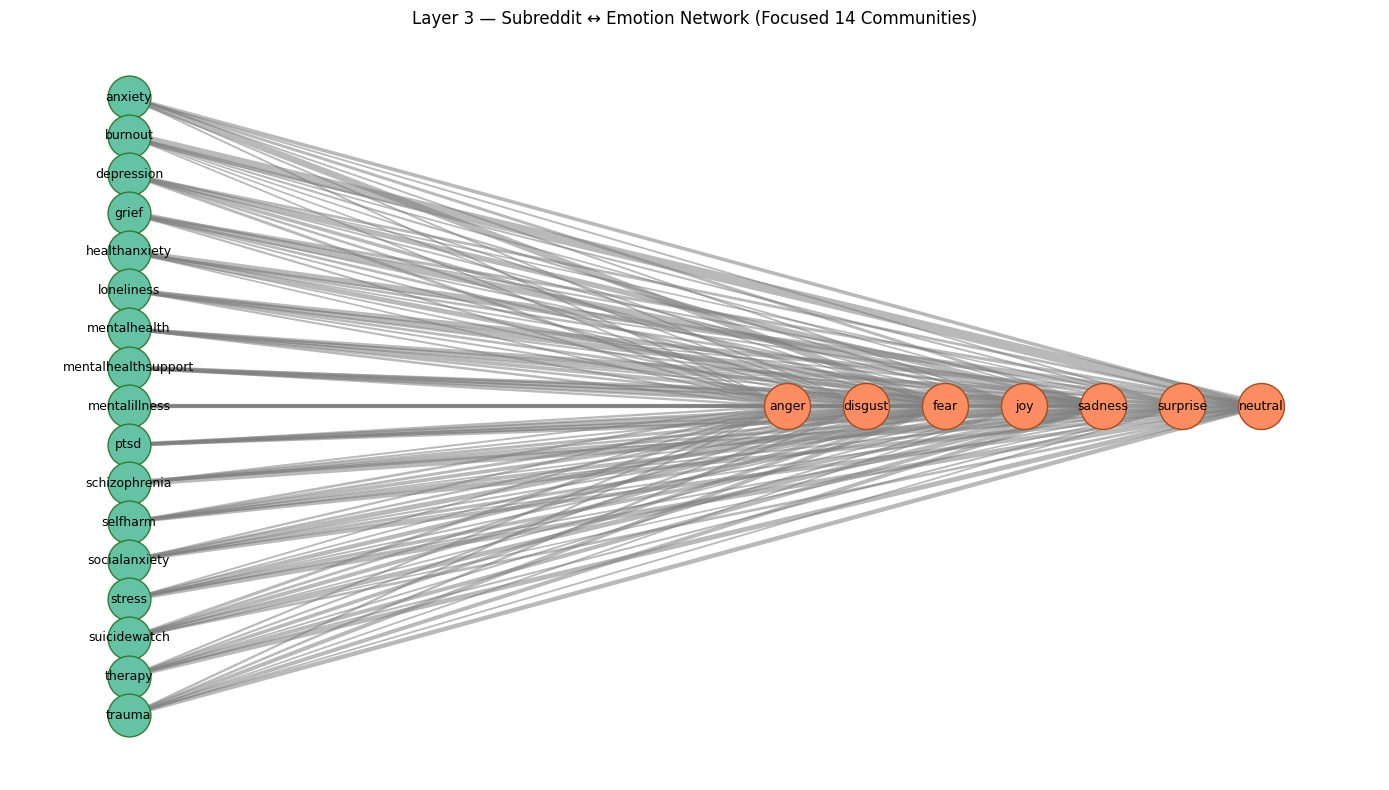


🔹 Top emotionally rich subreddits (weighted degree):
  depression                → 1.000
  stress                    → 1.000
  anxiety                   → 1.000
  burnout                   → 1.000
  grief                     → 1.000
  healthanxiety             → 1.000
  loneliness                → 1.000
  mentalhealth              → 1.000
  mentalhealthsupport       → 1.000
  mentalillness             → 1.000
  ptsd                      → 1.000
  schizophrenia             → 1.000
  selfharm                  → 1.000
  socialanxiety             → 1.000
  suicidewatch              → 1.000
  therapy                   → 1.000
  trauma                    → 1.000

🔹 Dominant emotions across subreddits:
  neutral    → 4.788
  sadness    → 4.130
  fear       → 3.976
  anger      → 1.319
  disgust    → 1.285
  joy        → 0.827
  surprise   → 0.676

✅ Saved detailed emotion matrix → layer3_subreddit_emotion_focused.csv


In [54]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 1️⃣ CONFIGURATION
# ---------------------------------------------------
CSV = "emotion_output_ekman_predicted.csv"
EMOTIONS = ["anger","disgust","fear","joy","sadness","surprise","neutral"]

# Target subreddits (canonical form: lowercase)
TARGET_SUBS = [
    "depression","anxiety","mentalhealth","suicidewatch","mentalillness",
    "healthanxiety","stress","mentalhealthsupport","loneliness","trauma",
    "socialanxiety","therapy","burnout","grief","ptsd","schizophrenia","selfharm"
]
TARGET_SUBS = [s.lower() for s in TARGET_SUBS]

# ---------------------------------------------------
# 2️⃣ LOAD AND PREP DATA
# ---------------------------------------------------
df = pd.read_csv(CSV)

# Ensure columns exist
for e in EMOTIONS:
    if e not in df.columns:
        raise ValueError(f"Missing emotion column: {e}")
if "subreddit" not in df.columns:
    raise ValueError("Missing column: subreddit")

# Normalize text case for subreddit names
df["subreddit"] = df["subreddit"].astype(str).str.lower().str.strip()

# Keep only target subreddits
df = df[df["subreddit"].isin(TARGET_SUBS)].copy()

print(f"✅ Filtered dataset to {len(df)} posts from {df['subreddit'].nunique()} key subreddits.")

# ---------------------------------------------------
# 3️⃣ AGGREGATE EMOTIONS PER SUBREDDIT
# ---------------------------------------------------
# Average emotion probabilities per subreddit
agg = df.groupby("subreddit")[EMOTIONS].mean()

# Normalize within subreddit so rows sum to 1
agg_norm = agg.div(agg.sum(axis=1), axis=0)

# ---------------------------------------------------
# 4️⃣ BUILD BIPARTITE NETWORK
# ---------------------------------------------------
B = nx.Graph()

subs = agg_norm.index.tolist()
B.add_nodes_from(subs, bipartite=0)          # subreddits (left)
B.add_nodes_from(EMOTIONS, bipartite=1)      # emotions (right)

for s in subs:
    for e in EMOTIONS:
        w = agg_norm.loc[s, e]
        if w > 0:
            B.add_edge(s, e, weight=float(w))

print(f"Graph built: {len(B.nodes())} nodes, {len(B.edges())} edges")

# ---------------------------------------------------
# 5️⃣ VISUALIZATION (Left = Subreddits, Right = Emotions)
# ---------------------------------------------------
plt.figure(figsize=(14, 8))

pos = {}
# Left: subreddits stacked vertically
y_step = 1.0 / (len(subs) + 1)
for i, s in enumerate(subs):
    pos[s] = (-0.85, 1 - (i + 1) * y_step)

# Right: emotions evenly spaced horizontally
x_positions = [0.15 + 0.12 * i for i in range(len(EMOTIONS))]
for j, e in enumerate(EMOTIONS):
    pos[e] = (x_positions[j], 0.5)

# Nodes
nx.draw_networkx_nodes(
    B, pos,
    nodelist=subs,
    node_color="#66c2a5",
    node_size=950,
    edgecolors="#2e7d32",
    label="Subreddits"
)
nx.draw_networkx_nodes(
    B, pos,
    nodelist=EMOTIONS,
    node_color="#fc8d62",
    node_size=1100,
    edgecolors="#a34d20",
    label="Emotions"
)

# Edges weighted by normalized emotion strength
edge_weights = [d["weight"] for _, _, d in B.edges(data=True)]
wmax = max(edge_weights) if edge_weights else 1
edge_widths = [1 + 6 * (w / wmax) for w in edge_weights]
nx.draw_networkx_edges(B, pos, width=edge_widths, edge_color="gray", alpha=0.55)

# Labels
nx.draw_networkx_labels(B, pos, font_size=9)

plt.title("Layer 3 — Subreddit ↔ Emotion Network (Focused 14 Communities)")
plt.axis("off")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 6️⃣ EMOTION PROFILES & METRICS
# ---------------------------------------------------
# Weighted degree (overall emotional richness per subreddit)
deg = {s: sum(d["weight"] for _, _, d in B.edges(s, data=True)) for s in subs}
deg_sorted = sorted(deg.items(), key=lambda x: -x[1])

print("\n🔹 Top emotionally rich subreddits (weighted degree):")
for s, val in deg_sorted:
    print(f"  {s:25s} → {val:.3f}")

# Emotion prominence (sum across all subreddits)
emo_centrality = {e: sum(d["weight"] for _, _, d in B.edges(e, data=True)) for e in EMOTIONS}
emo_sorted = sorted(emo_centrality.items(), key=lambda x: -x[1])

print("\n🔹 Dominant emotions across subreddits:")
for e, val in emo_sorted:
    print(f"  {e:10s} → {val:.3f}")

# Save aggregated emotion scores
agg_norm.to_csv("layer3_subreddit_emotion_focused.csv")
print("\n✅ Saved detailed emotion matrix → layer3_subreddit_emotion_focused.csv")


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/118425515.py:27: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



✅ Filtered to 43120 posts from 17 key subreddits.
✅ Using 7 emotion columns: ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']...
✅ Graph built: 24 nodes, 101 edges


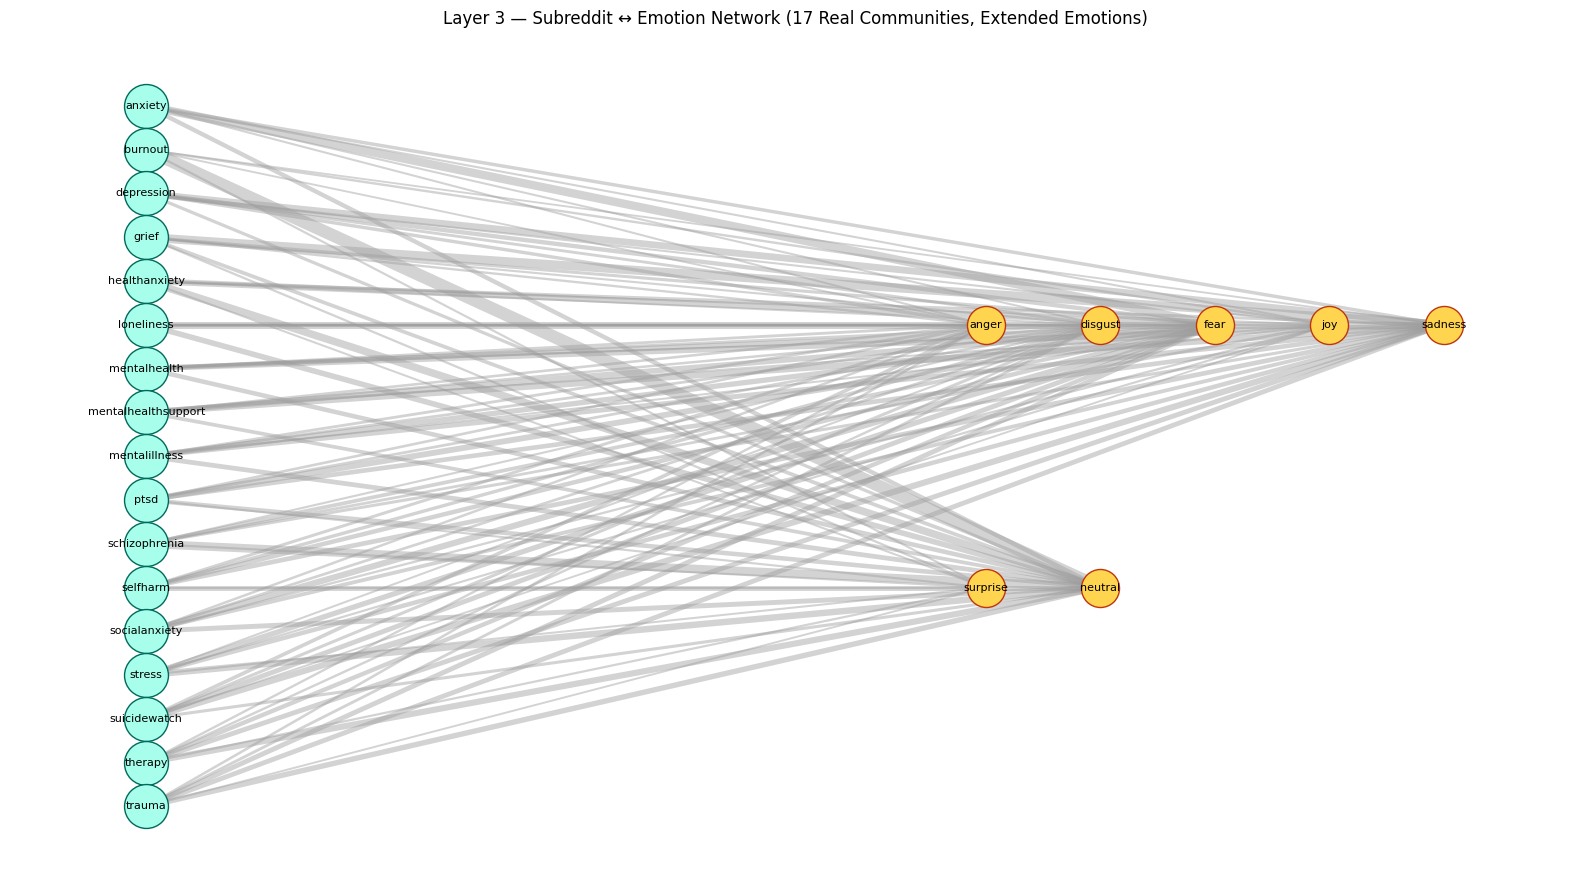


🔹 Emotional richness per subreddit:
  suicidewatch         → 0.982
  depression           → 0.980
  mentalhealthsupport  → 0.975
  loneliness           → 0.975
  healthanxiety        → 0.969
  mentalillness        → 0.967
  ptsd                 → 0.967
  trauma               → 0.965
  mentalhealth         → 0.964
  selfharm             → 0.962
  socialanxiety        → 0.960
  anxiety              → 0.959
  stress               → 0.957
  therapy              → 0.956
  grief                → 0.956
  schizophrenia        → 0.950
  burnout              → 0.948

🔹 Dominant emotions overall:
  neutral              → 4.788
  sadness              → 4.130
  fear                 → 3.950
  disgust              → 1.259
  anger                → 1.195
  joy                  → 0.633
  surprise             → 0.437

✅ Saved matrix → layer3_subreddit_emotion_final.csv


In [56]:
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ======================
# CONFIGURATION
# ======================
CSV = "emotion_output_ekman_predicted.csv"
SUBREDDIT_COL = "subreddit"

# exact subreddits from your dataset
TARGET_SUBS = [
    "depression","stress","anxiety","burnout","grief","healthanxiety",
    "loneliness","mentalhealth","mentalhealthsupport","mentalillness",
    "ptsd","schizophrenia","selfharm","socialanxiety","suicidewatch",
    "therapy","trauma"
]

TOP_EMOTIONS_PER_SUB = 6   # keep strongest 6 emotions per subreddit
MIN_EDGE_WEIGHT = 0.03      # ignore weak edges for clarity

# ======================
# 1) LOAD AND CLEAN
# ======================
df = pd.read_csv(CSV)

# clean subreddit names
df[SUBREDDIT_COL] = df[SUBREDDIT_COL].astype(str).str.lower().str.strip()
df = df[df[SUBREDDIT_COL].isin(TARGET_SUBS)].copy()
print(f"✅ Filtered to {len(df)} posts from {df[SUBREDDIT_COL].nunique()} key subreddits.")

# ======================
# 2) AUTO-DETECT EMOTION COLUMNS
# ======================
possible_emotions = [
    # GoEmotions (28)
    "admiration","amusement","anger","annoyance","approval","caring",
    "confusion","curiosity","desire","disappointment","disapproval",
    "disgust","embarrassment","excitement","fear","gratitude","grief",
    "joy","love","nervousness","optimism","pride","realization",
    "relief","remorse","sadness","surprise","neutral",
    # Ekman 7
    "anger","disgust","fear","joy","sadness","surprise","neutral"
]

emo_cols = [c for c in df.columns if c.lower() in possible_emotions]
if not emo_cols:
    raise ValueError("❌ No emotion columns detected in file.")
print(f"✅ Using {len(emo_cols)} emotion columns: {emo_cols[:10]}...")

# ensure numeric
df[emo_cols] = df[emo_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# ======================
# 3) AGGREGATE EMOTION PROBABILITIES PER SUBREDDIT
# ======================
agg = df.groupby(SUBREDDIT_COL)[emo_cols].mean()
agg_norm = agg.div(agg.sum(axis=1), axis=0).fillna(0)

# ======================
# 4) BUILD BIPARTITE NETWORK
# ======================
B = nx.Graph()
subs = agg_norm.index.tolist()
B.add_nodes_from(subs, bipartite=0)
B.add_nodes_from(emo_cols, bipartite=1)

for s in subs:
    row = agg_norm.loc[s]
    top_emotions = row.sort_values(ascending=False)
    kept = 0
    for e, w in top_emotions.items():
        if w < MIN_EDGE_WEIGHT:
            continue
        B.add_edge(s, e, weight=w)
        kept += 1
        if kept >= TOP_EMOTIONS_PER_SUB:
            break

print(f"✅ Graph built: {len(B.nodes())} nodes, {len(B.edges())} edges")

# ======================
# 5) VISUALIZE NETWORK
# ======================
plt.figure(figsize=(16, 9))
pos = {}

# left: subreddits stacked vertically
y_step = 1.0 / (len(subs) + 1)
for i, s in enumerate(subs):
    pos[s] = (-0.95, 1 - (i + 1) * y_step)

# right: emotions arranged in 5 columns
cols = 5
rows = int(np.ceil(len(emo_cols) / cols))
x_positions = [0.15 + 0.15 * i for i in range(cols)]
y_positions = [1 - (r + 1) * (1.0 / (rows + 1)) for r in range(rows)]
for idx, e in enumerate(emo_cols):
    cx = idx % cols
    ry = idx // cols
    pos[e] = (x_positions[cx], y_positions[ry])

# draw nodes
nx.draw_networkx_nodes(B, pos, nodelist=subs,
                       node_color="#a7ffeb", node_size=1000, edgecolors="#00695c")
nx.draw_networkx_nodes(B, pos, nodelist=emo_cols,
                       node_color="#ffd54f", node_size=750, edgecolors="#bf360c")

# draw edges scaled by weight
weights = [d["weight"] for _,_,d in B.edges(data=True)]
max_w = max(weights) if weights else 1
nx.draw_networkx_edges(
    B, pos,
    width=[1 + 8*(w/max_w) for w in weights],
    edge_color="#9e9e9e", alpha=0.45
)

nx.draw_networkx_labels(B, pos, font_size=8)
plt.title("Layer 3 — Subreddit ↔ Emotion Network (17 Real Communities, Extended Emotions)")
plt.axis("off"); plt.tight_layout(); plt.show()

# ======================
# 6) METRICS
# ======================
deg = {s: sum(d["weight"] for _,_,d in B.edges(s, data=True)) for s in subs}
print("\n🔹 Emotional richness per subreddit:")
for s, v in sorted(deg.items(), key=lambda x: -x[1]):
    print(f"  {s:20s} → {v:.3f}")

emo_strength = {e: sum(d["weight"] for _,_,d in B.edges(e, data=True)) for e in emo_cols}
print("\n🔹 Dominant emotions overall:")
for e, v in sorted(emo_strength.items(), key=lambda x: -x[1])[:10]:
    print(f"  {e:20s} → {v:.3f}")

agg_norm.to_csv("layer3_subreddit_emotion_final.csv")
print("\n✅ Saved matrix → layer3_subreddit_emotion_final.csv")


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/1084633940.py:14: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("emotion_output_ekman_predicted_top3.csv")  # change as needed
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harjaap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


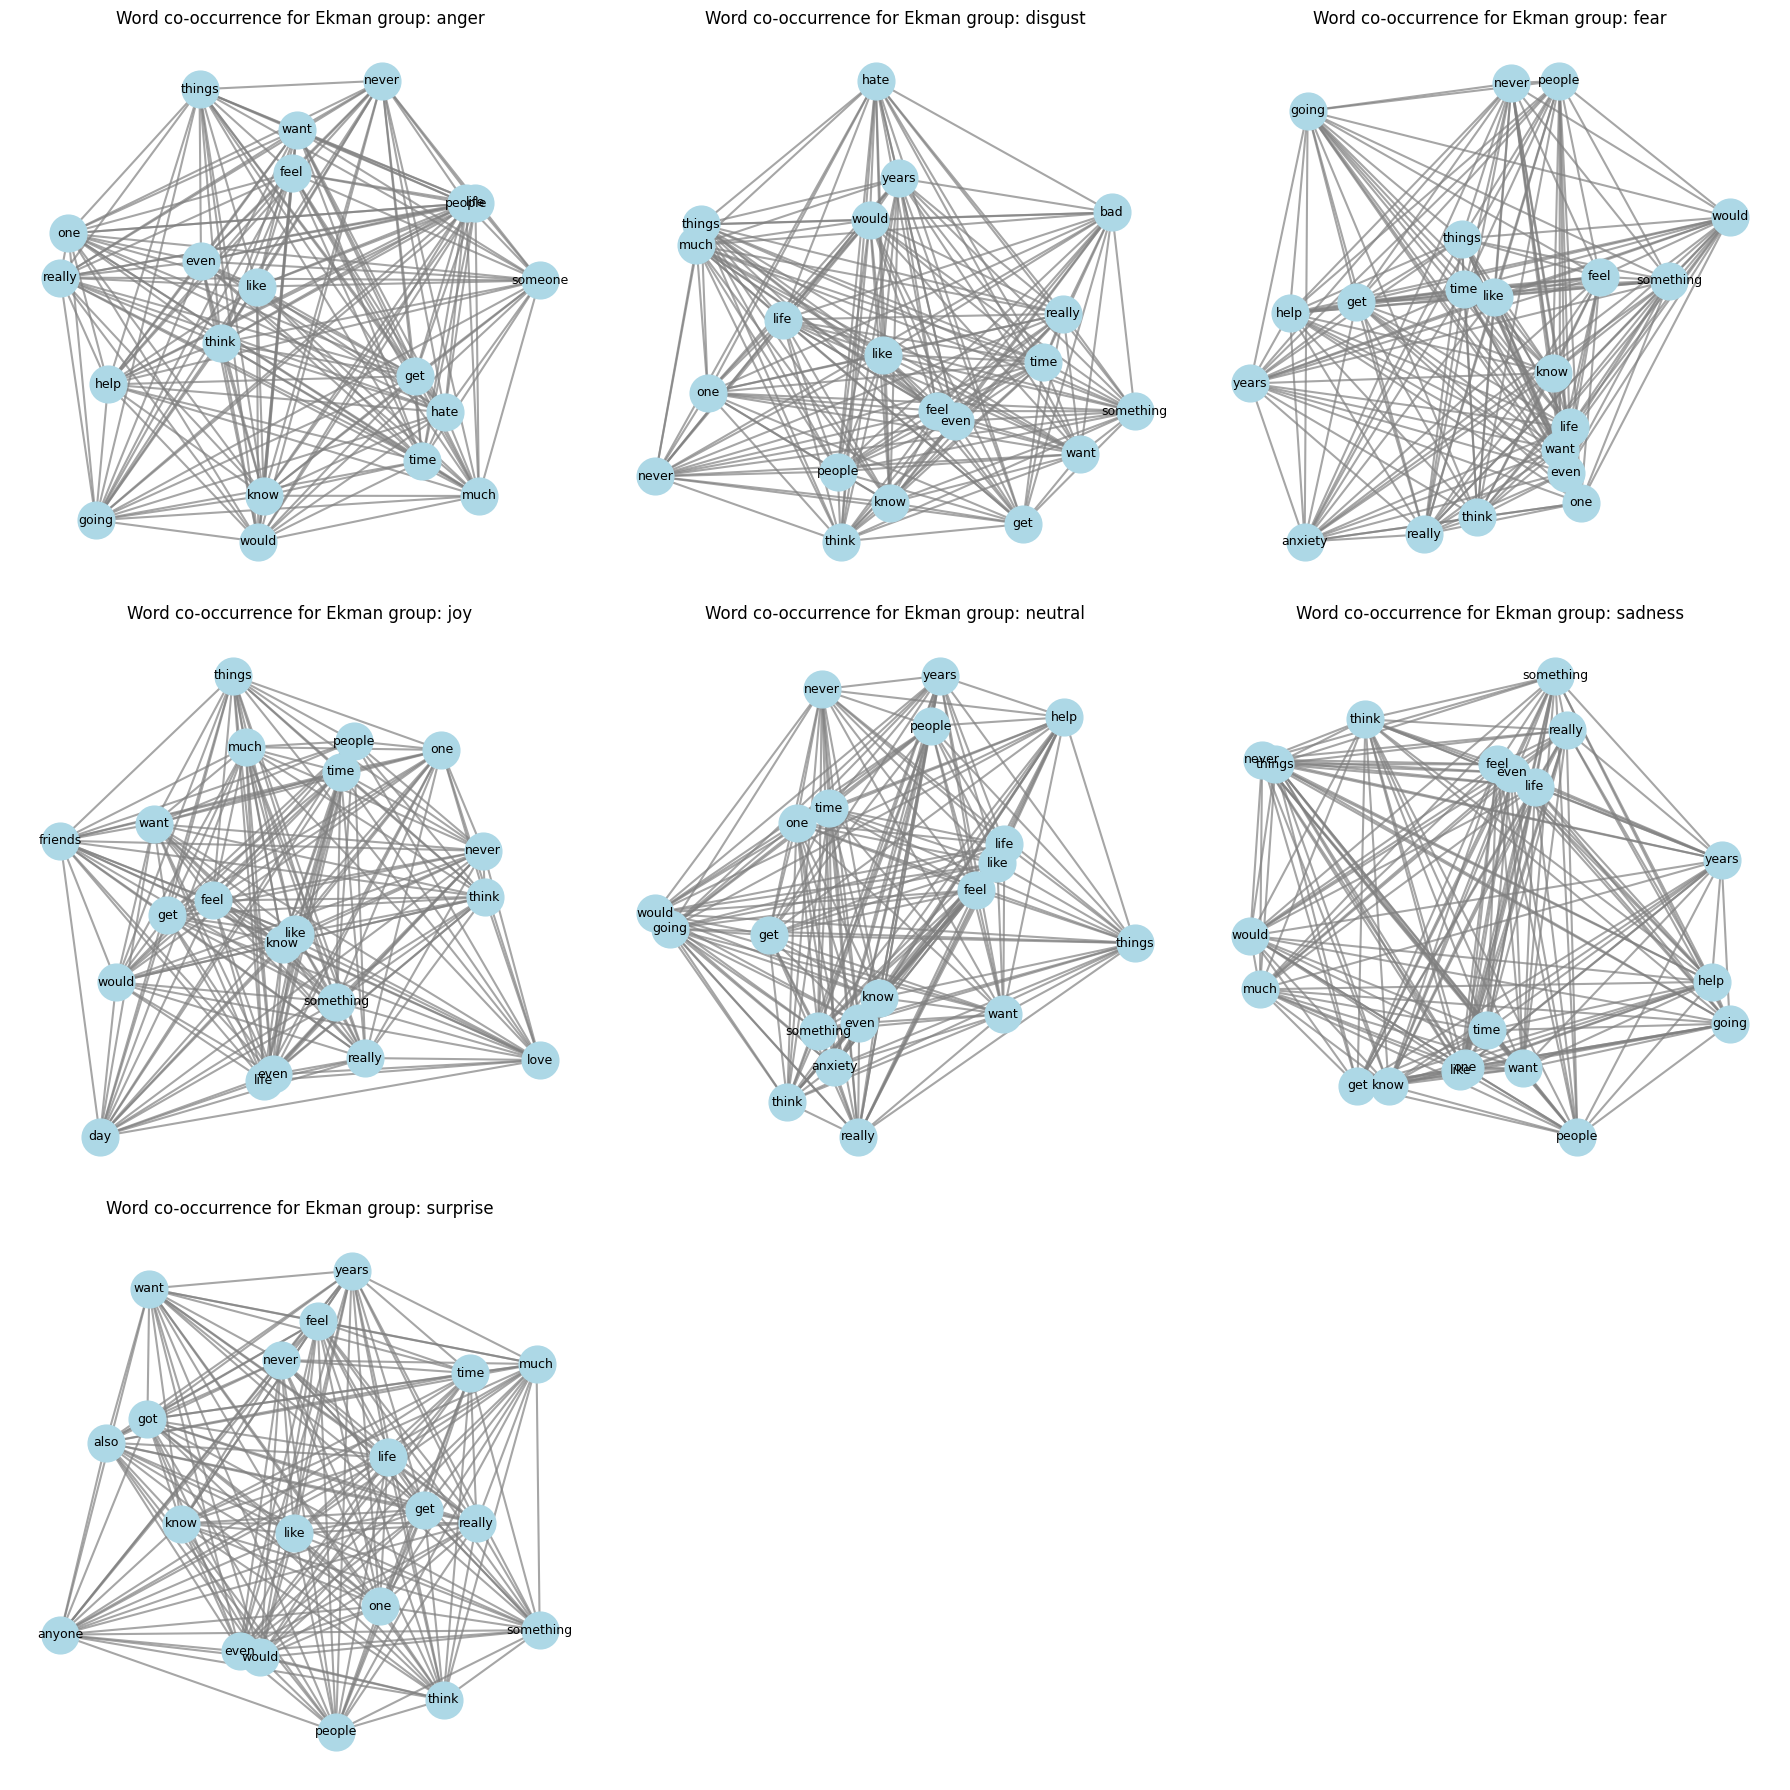

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import itertools
import nltk
from nltk.corpus import stopwords
import re

# ----------------------------
# 1. Load your Ekman dataset
# ----------------------------

df = pd.read_csv("emotion_output_ekman_predicted_top3.csv")  # change as needed

# Identify text column
text_col = "clean_text"   # change if needed

# Ensure top_3_ekman is a list
def to_list(s):
    if pd.isna(s):
        return []
    return [x.strip() for x in str(s).split(",") if x.strip()]

df["emo_list"] = df["top_3_ekman"].apply(to_list)

# ----------------------------
# 2. Basic preprocessing
# ----------------------------

nltk.download("stopwords")
stop = set(stopwords.words("english"))

def tokenize(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    words = [w for w in text.split() if w not in stop and len(w) > 2]
    return words

df["tokens"] = df[text_col].apply(tokenize)

# ------------------------------------------------
# 3. Build word co-occurrence per Ekman emotion
# ------------------------------------------------

ekman_groups = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]

def build_word_cooccur(tokens_list, top_n=20):
    """
    tokens_list = list of token lists
    """
    # count word frequency
    freq = Counter()
    for toks in tokens_list:
        freq.update(toks)

    # keep only top N words
    vocab = set([w for w, _ in freq.most_common(top_n)])

    # build co-occurrence counter
    co = Counter()
    for toks in tokens_list:
        toks = [t for t in toks if t in vocab]
        for w1, w2 in itertools.combinations(sorted(set(toks)), 2):
            co[(w1, w2)] += 1

    # build graph
    G = nx.Graph()
    G.add_nodes_from(vocab)

    for (w1, w2), w in co.items():
        G.add_edge(w1, w2, weight=w)

    return G

# ------------------------------------------------
# 4. Build network per Ekman emotion
# ------------------------------------------------

emotion_networks = {}

for emo in ekman_groups:
    # get all posts where emo is in top_3_ekman
    subset = df[df["emo_list"].apply(lambda x: emo in x)]
    tokens_list = subset["tokens"].tolist()

    if len(tokens_list) == 0:
        continue
    
    G = build_word_cooccur(tokens_list, top_n=20)
    emotion_networks[emo] = G

# ------------------------------------------------
# 5. Plot all networks in one grid
# ------------------------------------------------

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

pos_cache = {}  # to re-use layout

for idx, emo in enumerate(ekman_groups):
    ax = axes[idx]

    if emo not in emotion_networks:
        ax.axis("off")
        continue

    G = emotion_networks[emo]

    # spring layout (cached for consistency)
    if idx not in pos_cache:
        pos_cache[idx] = nx.spring_layout(G, seed=42)
    pos = pos_cache[idx]

    # draw edges
    nx.draw_networkx_edges(
        G, pos, ax=ax, width=1.5, edge_color="gray", alpha=0.7
    )

    # draw normal nodes
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[n for n in G.nodes() if n != emo],
        node_size=700,
        node_color="#add8e6",  # light blue
        ax=ax
    )

    # draw target emotion in red
    if emo in G.nodes():
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=[emo],
            node_size=900,
            node_color="red",
            ax=ax
        )

    # labels
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    ax.set_title(f"Word co-occurrence for Ekman group: {emo}", fontsize=12)
    ax.axis("off")

# Turn off remaining empty panels (if any)
for j in range(idx+1, 9):
    axes[j].axis("off")

plt.tight_layout()
plt.savefig("ekman_word_cooccurrence_grid.png", dpi=300)
plt.show()


In [58]:
import pandas as pd

# Load your file
df = pd.read_csv("emotion_output_ekman_predicted.csv")

# Official GoEmotions → Ekman-7 mapping
ekman_map = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "joy": [
        "amusement", "approval", "caring", "curiosity", "desire", "excitement",
        "gratitude", "joy", "love", "optimism", "pride", "realization",
        "relief", "admiration"
    ],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief", "remorse"],
    "surprise": ["confusion", "surprise"],
    "neutral": ["neutral"]
}

# Verify columns and compute new Ekman-level averages
available = set(df.columns)
for ek, sublist in ekman_map.items():
    cols = [c for c in sublist if c in available]
    if not cols:
        print(f"⚠️  No matching columns found for Ekman emotion '{ek}'")
        df[f"ekman_{ek}"] = 0.0
    else:
        df[f"ekman_{ek}"] = df[cols].mean(axis=1)

# Save new CSV with 7 Ekman columns added
out_path = "emotion_output_with_ekman7_official.csv"
df.to_csv(out_path, index=False)

print(f"✅ File saved: {out_path}")
print("Added Ekman columns:", [f"ekman_{e}" for e in ekman_map.keys()])


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/3963214550.py:4: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



✅ File saved: emotion_output_with_ekman7_official.csv
Added Ekman columns: ['ekman_anger', 'ekman_disgust', 'ekman_fear', 'ekman_joy', 'ekman_sadness', 'ekman_surprise', 'ekman_neutral']


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/3000660583.py:33: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



Graph: 52 nodes, 121 edges


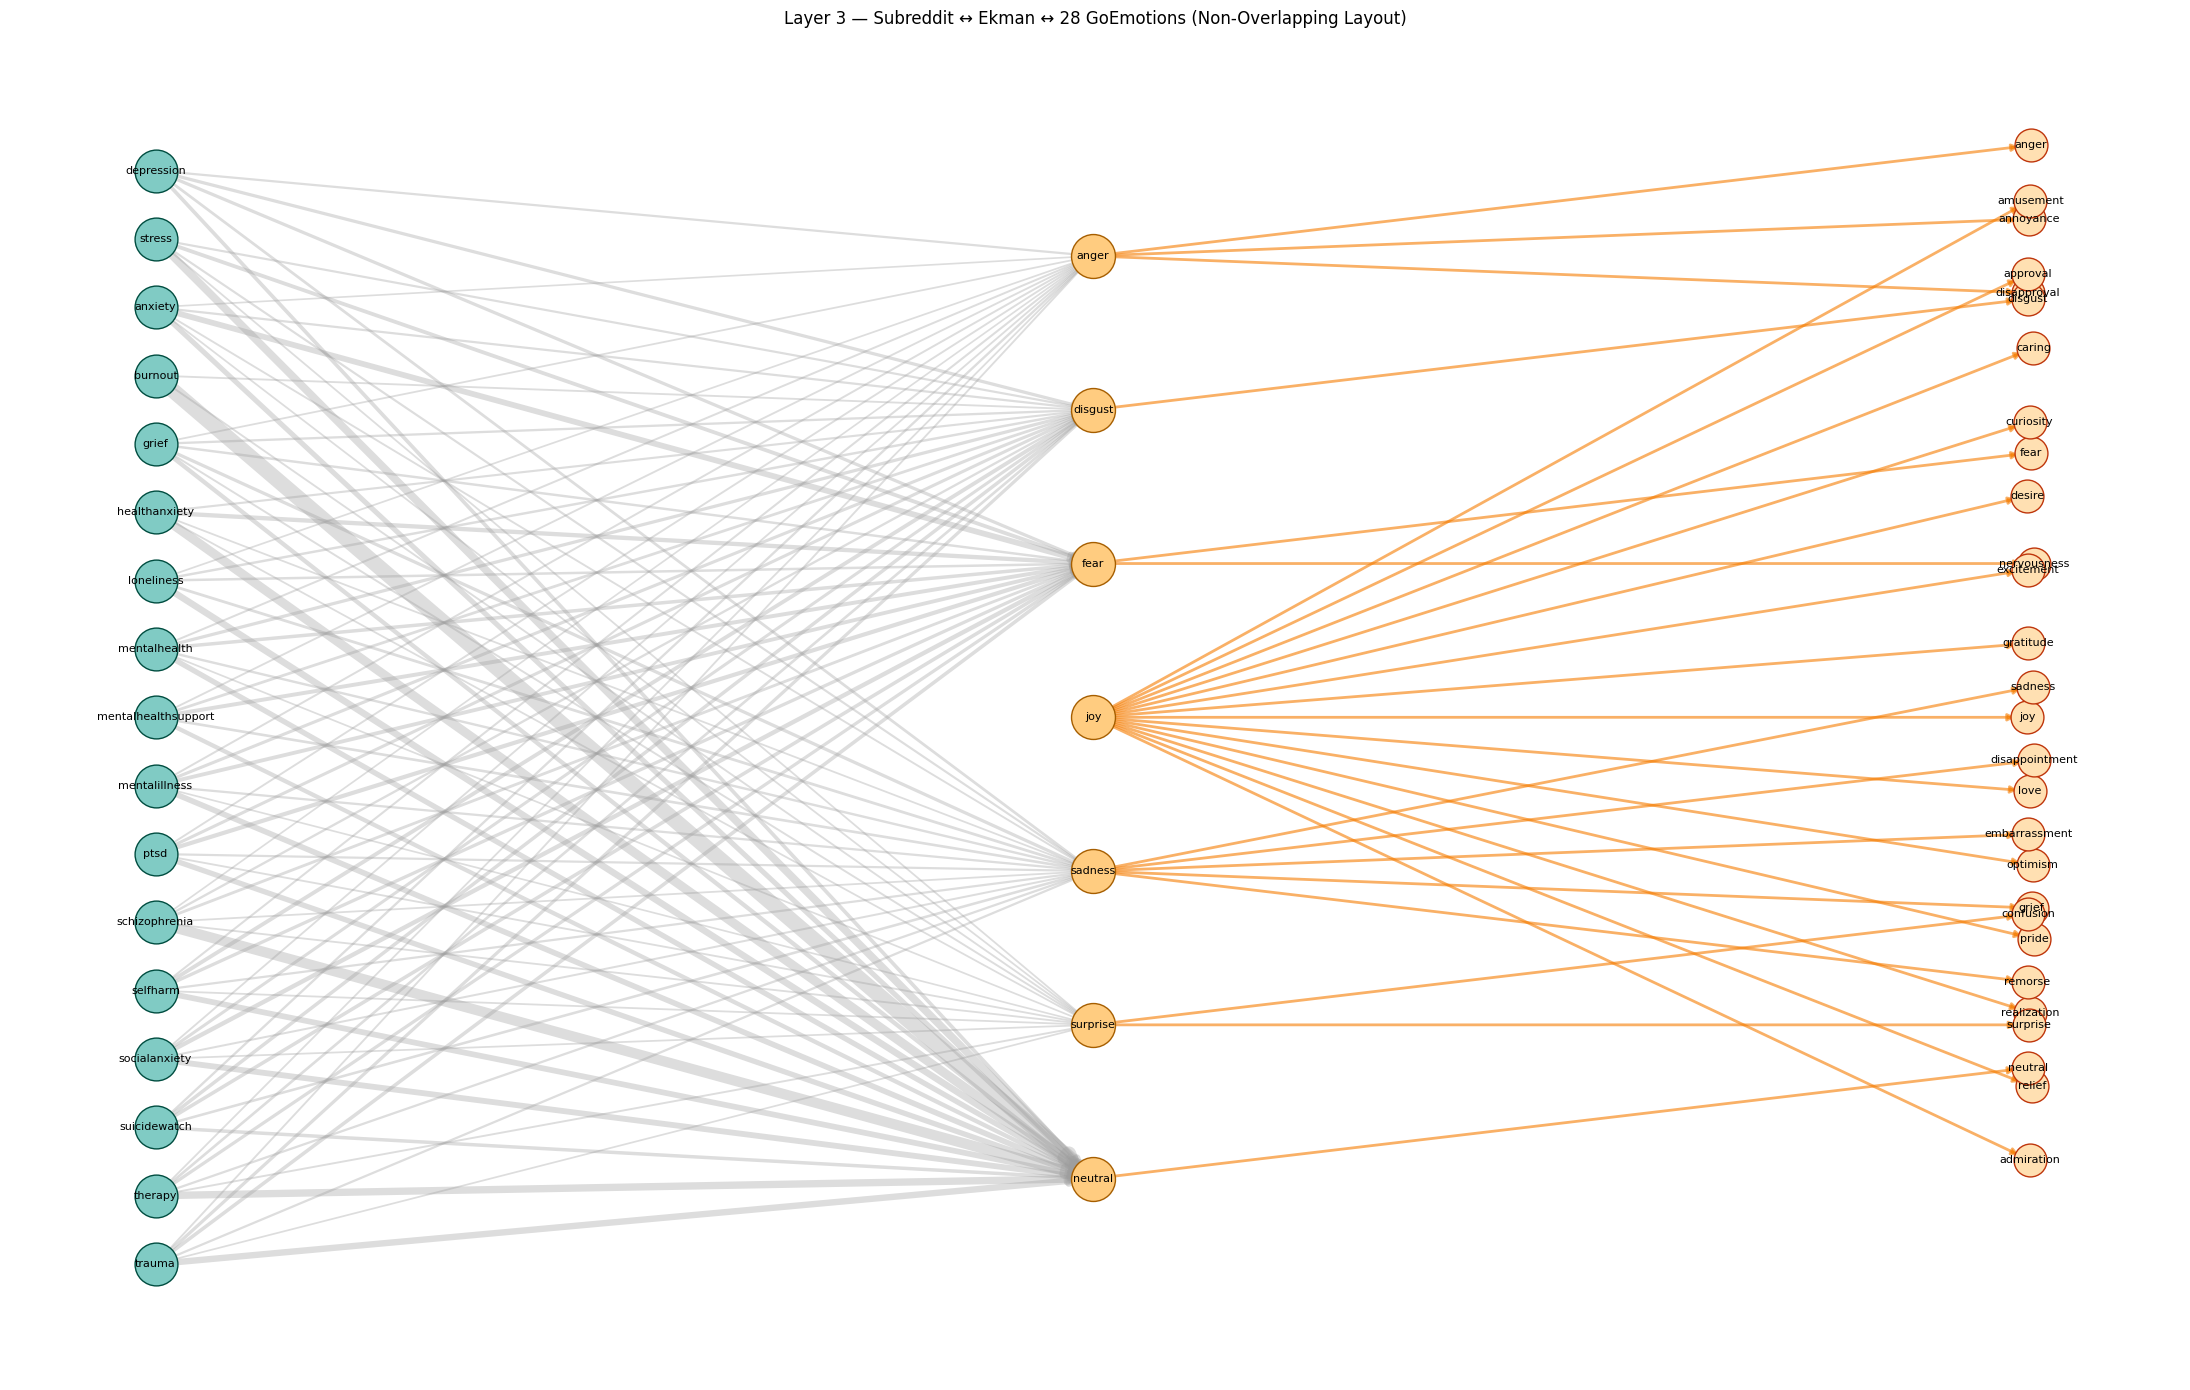

In [65]:
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ================== CONFIG ==================
CSV = "emotion_output_ekman_predicted.csv"
SUBREDDIT_COL = "subreddit"
SUBS = [
    "depression","stress","anxiety","burnout","grief","healthanxiety",
    "loneliness","mentalhealth","mentalhealthsupport","mentalillness",
    "ptsd","schizophrenia","selfharm","socialanxiety","suicidewatch",
    "therapy","trauma"
]
# Official GoEmotions -> Ekman mapping
ekman_map = {
    "anger":   ["anger","annoyance","disapproval"],
    "disgust": ["disgust"],
    "fear":    ["fear","nervousness"],
    "joy":     ["amusement","approval","caring","curiosity","desire",
                "excitement","gratitude","joy","love","optimism","pride",
                "realization","relief","admiration"],
    "sadness": ["sadness","disappointment","embarrassment","grief","remorse"],
    "surprise":["confusion","surprise"],
    "neutral": ["neutral"],
}
GOE28 = [g for gs in ekman_map.values() for g in gs]
SUB_EK_EDGE_MIN = 0.015
EK_GO_EDGE_W = 0.35

# ================== LOAD & NORMALIZE ==================
df = pd.read_csv(CSV)
df[SUBREDDIT_COL] = df[SUBREDDIT_COL].astype(str).str.lower().str.strip()
df = df[df[SUBREDDIT_COL].isin(SUBS)].copy()

# Normalize emotion column names
def canon(s): 
    s = s.lower().strip()
    for pre in ("goe_", "emotion_", "pred_", "prob_", "label_"):
        if s.startswith(pre): s = s[len(pre):]
    return s.replace("-", "_")

canon_cols = {c: canon(c) for c in df.columns}
goe_scores = pd.DataFrame(index=df.index)
for g in GOE28:
    match = [c for c in df.columns if canon_cols[c] == g]
    if match:
        goe_scores[g] = pd.to_numeric(df[match[0]], errors="coerce").fillna(0).clip(0,1)
    else:
        goe_scores[g] = 0

agg = pd.concat([df[[SUBREDDIT_COL]], goe_scores], axis=1).groupby(SUBREDDIT_COL)[GOE28].mean()
agg_norm = agg.div(agg.sum(axis=1), axis=0).fillna(0)

sub_ek_strength = {
    s: {ek: agg_norm.loc[s, gos].mean() for ek, gos in ekman_map.items()} for s in agg_norm.index
}

# ================== BUILD GRAPH ==================
G = nx.DiGraph()
def nid(kind, name): return f"{kind}::{name}"

for s in SUBS:
    G.add_node(nid("sub", s), kind="sub", label=s)
for ek in ekman_map:
    G.add_node(nid("ek", ek), kind="ek", label=ek)
for g in GOE28:
    G.add_node(nid("go", g), kind="go", label=g)

# Edges
for ek, gos in ekman_map.items():
    for g in gos:
        G.add_edge(nid("ek", ek), nid("go", g), weight=EK_GO_EDGE_W, etype="ek_go")
for s in SUBS:
    for ek, gos in ekman_map.items():
        w = sub_ek_strength.get(s, {}).get(ek, 0)
        if w >= SUB_EK_EDGE_MIN:
            G.add_edge(nid("sub", s), nid("ek", ek), weight=w, etype="sub_ek")

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ================== IMPROVED LAYOUT ==================
plt.figure(figsize=(22, 14))
pos = {}

# Left layer: subreddits
y_step = 1.0 / (len(SUBS) + 1)
for i, s in enumerate(SUBS):
    pos[nid("sub", s)] = (-1.3, 1 - (i + 1) * y_step)

# Middle layer: Ekman
ekmans = list(ekman_map.keys())
for i, ek in enumerate(ekmans):
    pos[nid("ek", ek)] = (0.0, 1 - (i + 1) * (1.0 / (len(ekmans) + 1)))

# Right layer: GoEmotions, expanded vertically with jitter
x_right = 1.3
for i, ek in enumerate(ekmans):
    children = ekman_map[ek]
    base_y = pos[nid("ek", ek)][1]
    spread = 0.06 * max(3, len(children))  # expanded vertical spread
    for j, g in enumerate(children):
        jitter = (np.random.rand() - 0.5) * 0.01  # tiny horizontal offset
        y = base_y + spread/2 - j * (spread / len(children))
        pos[nid("go", g)] = (x_right + jitter, y)

# ================== DRAW ==================
subs_nodes = [n for n,d in G.nodes(data=True) if d["kind"]=="sub"]
ek_nodes = [n for n,d in G.nodes(data=True) if d["kind"]=="ek"]
go_nodes = [n for n,d in G.nodes(data=True) if d["kind"]=="go"]

nx.draw_networkx_nodes(G,pos,nodelist=subs_nodes,node_color="#80cbc4",node_size=950,edgecolors="#004d40")
nx.draw_networkx_nodes(G,pos,nodelist=ek_nodes,node_color="#ffcc80",node_size=1000,edgecolors="#a65e00")
nx.draw_networkx_nodes(G,pos,nodelist=go_nodes,node_color="#ffe0b2",node_size=560,edgecolors="#bf360c")

edges_sub_ek = [(u,v) for u,v,d in G.edges(data=True) if d.get("etype")=="sub_ek"]
edges_ek_go  = [(u,v) for u,v,d in G.edges(data=True) if d.get("etype")=="ek_go"]

w_sub = [G[u][v]["weight"] for u,v in edges_sub_ek]
wmax  = max(w_sub) if w_sub else 1.0

nx.draw_networkx_edges(G,pos,edgelist=edges_sub_ek,
    width=[1+10*(w/wmax) for w in w_sub],edge_color="#9e9e9e",alpha=0.35)
nx.draw_networkx_edges(G,pos,edgelist=edges_ek_go,
    width=2,edge_color="#f57c00",alpha=0.6)

nx.draw_networkx_labels(G,pos,{n:d["label"] for n,d in G.nodes(data=True)},font_size=8)
plt.title("Layer 3 — Subreddit ↔ Ekman ↔ 28 GoEmotions (Non-Overlapping Layout)")
plt.axis("off"); plt.tight_layout(); plt.show()


In [69]:
import pandas as pd, numpy as np, itertools, math, random
from collections import Counter
import networkx as nx
from tqdm import trange

# ==========================================
# 1️⃣ Load data and parse emotions per post
# ==========================================
df = pd.read_csv("emotion_output_ekman_predicted_top3.csv")
EMOS = ["anger","disgust","fear","joy","sadness","surprise","neutral"]

def parse_list(s):
    """Parse list-like string ['anger','sadness'] → ['anger','sadness']"""
    if isinstance(s, list): return s
    if pd.isna(s): return []
    s = str(s).strip()
    if s.startswith("["): s = s[1:]
    if s.endswith("]"): s = s[:-1]
    return [x.strip().strip("'\"") for x in s.split(",") if x.strip() in EMOS]

posts = [sorted(set(parse_list(x))) for x in df["top_3_ekman"]]
posts = [p for p in posts if p]  # remove empty
N = len(posts)
assert N > 0, "No valid posts found!"

print(f"[L1] Parsed {N:,} posts with Ekman emotions")

# ==========================================
# 2️⃣ Compute Positive PMI matrix
# ==========================================
e_cnt = Counter(itertools.chain.from_iterable(posts))
pair_cnt = Counter(tuple(sorted(p)) for P in posts for p in itertools.combinations(P, 2))

p_e = {e: e_cnt[e]/N for e in EMOS}
p_ij = {ij: c/N for ij,c in pair_cnt.items()}

def ppmi(i, j):
    pij = p_ij.get(tuple(sorted((i, j))), 0)
    if pij == 0 or p_e[i] == 0 or p_e[j] == 0:
        return 0.0
    val = math.log2(pij / (p_e[i]*p_e[j]))
    return max(val, 0.0)

W = {(i, j): ppmi(i, j) for i, j in itertools.combinations(EMOS, 2)}
nonzero = {k:v for k,v in W.items() if v>0}
print(f"[L1] Non-zero edges: {len(nonzero)}/{len(W)}; strongest:", sorted(nonzero.items(), key=lambda x:-x[1])[:5])

# ==========================================
# 3️⃣ Null model: shuffle emotions per post
# ==========================================
R = 200  # number of random shuffles (increase for smoother estimate)
rng = np.random.default_rng(42)

def shuffle_null_once():
    """Shuffles emotion labels across posts while preserving number of emotions per post."""
    flat = list(itertools.chain.from_iterable(posts))
    rng.shuffle(flat)
    rebuilt, idx = [], 0
    for P in posts:
        k = len(P)
        rebuilt.append(sorted(set(flat[idx:idx+k])))
        idx += k

    ec = Counter(itertools.chain.from_iterable(rebuilt))
    pc = Counter(tuple(sorted(p)) for P in rebuilt for p in itertools.combinations(P,2))
    p_e0 = {e: ec[e]/N for e in EMOS}
    p_ij0 = {ij: c/N for ij,c in pc.items()}

    def _pp(i,j):
        pij = p_ij0.get(tuple(sorted((i,j))), 0)
        if pij==0 or p_e0[i]==0 or p_e0[j]==0: return 0.0
        val = math.log2(pij/(p_e0[i]*p_e0[j]))
        return max(val, 0.0)

    return {tuple(sorted((i,j))): _pp(i,j) for i,j in itertools.combinations(EMOS,2)}

print(f"[L1] Generating {R} null models...")
null_samples = [shuffle_null_once() for _ in trange(R)]

# ==========================================
# 4️⃣ Compute empirical p-values
# ==========================================
pvals = {}
for ij, obs in W.items():
    if obs <= 0:
        pvals[ij] = 1.0
    else:
        dist = np.array([s.get(ij, 0.0) for s in null_samples])
        pvals[ij] = (np.sum(dist >= obs) + 1) / (R + 1)

sig_edges = [(ij, W[ij], pvals[ij]) for ij in W if pvals[ij] <= 0.05 and W[ij] > 0]
print(f"\n[L1] Significant edges @ α=0.05: {len(sig_edges)}")
for (ij, w, p) in sorted(sig_edges, key=lambda x:-x[1])[:10]:
    print(f"  {ij}: weight={w:.3f}, p={p:.3f}")

# ==========================================
# 5️⃣ Robustness test — bootstrap edge stability
# ==========================================
def bootstrap_edges(B=100, frac=0.8):
    edge_lists = []
    for _ in trange(B, desc="Bootstrapping"):
        sample_idx = rng.choice(np.arange(N), size=int(frac*N), replace=True)
        samp_posts = [posts[i] for i in sample_idx]
        ec = Counter(itertools.chain.from_iterable(samp_posts))
        pc = Counter(tuple(sorted(p)) for P in samp_posts for p in itertools.combinations(P,2))
        p_e0 = {e: ec[e]/len(samp_posts) for e in EMOS}
        p_ij0 = {ij: c/len(samp_posts) for ij,c in pc.items()}

        def _pp(i,j):
            pij = p_ij0.get(tuple(sorted((i,j))), 0)
            if pij==0 or p_e0[i]==0 or p_e0[j]==0: return 0.0
            val = math.log2(pij/(p_e0[i]*p_e0[j])); return max(val,0.0)

        Wij = {tuple(sorted((i,j))): _pp(i,j) for i,j in itertools.combinations(EMOS,2)}
        edge_lists.append(Wij)

    cutoff = np.percentile([v for v in nonzero.values()], 30) if nonzero else 0.0
    stability = {ij: np.mean([e.get(ij,0.0) > cutoff for e in edge_lists]) for ij in W}
    return stability

stab = bootstrap_edges(B=100, frac=0.8)
print("\n[L1] Top stable edges (presence rate):")
for (ij, s) in sorted(stab.items(), key=lambda x:-x[1])[:10]:
    print(f"  {ij}: {s:.3f}")


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_66226/2507548926.py:9: DtypeWarning:

Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.



[L1] Parsed 43,733 posts with Ekman emotions
[L1] Non-zero edges: 5/21; strongest: [(('joy', 'surprise'), 0.9928477165115913), (('anger', 'disgust'), 0.7134195055473325), (('surprise', 'neutral'), 0.16441572230406226), (('fear', 'sadness'), 0.15762445515866685), (('joy', 'neutral'), 0.1269650277926491)]
[L1] Generating 200 null models...


100%|██████████| 200/200 [00:50<00:00,  3.94it/s]



[L1] Significant edges @ α=0.05: 5
  ('joy', 'surprise'): weight=0.993, p=0.005
  ('anger', 'disgust'): weight=0.713, p=0.005
  ('surprise', 'neutral'): weight=0.164, p=0.005
  ('fear', 'sadness'): weight=0.158, p=0.005
  ('joy', 'neutral'): weight=0.127, p=0.005


Bootstrapping: 100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


[L1] Top stable edges (presence rate):
  ('anger', 'disgust'): 1.000
  ('joy', 'surprise'): 1.000
  ('fear', 'sadness'): 0.330
  ('anger', 'fear'): 0.000
  ('anger', 'joy'): 0.000
  ('anger', 'sadness'): 0.000
  ('anger', 'surprise'): 0.000
  ('anger', 'neutral'): 0.000
  ('disgust', 'fear'): 0.000
  ('disgust', 'joy'): 0.000


In [13]:
import pandas as pd
import numpy as np
from itertools import combinations
import ast

def build_goemotion_cooc_network(csv_path, top_emotions_col="top_emotions", min_count=20):
    """
    Build a GoEmotions co-occurrence matrix from a dataset.
    Each row has a list of emotions (2-3 per post).
    """
    df = pd.read_csv(csv_path)

    # Parse top_emotions into real Python lists if stored as string
    def parse_list(x):
        if isinstance(x, list):
            return x
        try:
            return ast.literal_eval(x)
        except Exception:
            return []

    df[top_emotions_col] = df[top_emotions_col].apply(parse_list)

    # Collect unique emotions
    all_emotions = sorted({
        emo
        for lst in df[top_emotions_col]
        for emo in lst
        if isinstance(lst, (list, tuple))
    })

    # Initialize co-occurrence matrix
    cooc = pd.DataFrame(
        0,
        index=all_emotions,
        columns=all_emotions,
        dtype=int
    )

    # Fill co-occurrence counts
    for emos in df[top_emotions_col]:
        emos = list(set([e for e in emos if e in all_emotions]))
        if len(emos) < 2:
            continue
        for e1, e2 in combinations(emos, 2):
            cooc.loc[e1, e2] += 1
            cooc.loc[e2, e1] += 1

    # Remove super-rare links for clarity
    cooc_filtered = cooc.where(cooc >= min_count, 0)

    return cooc, cooc_filtered


In [14]:
# Reddit
cooc_reddit, cooc_reddit_f = build_goemotion_cooc_network(
    "emotion_output.csv",
    top_emotions_col="top_emotions",
    min_count=20   # adjust if graph too sparse/dense
)

# BeyondBlue
cooc_bb, cooc_bb_f = build_goemotion_cooc_network(
    "bb_emotion_output.csv",
    top_emotions_col="top_emotions",
    min_count=10   # maybe lower threshold if BB is smaller
)


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/3511340758.py:11: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [11]:
import ast
import numpy as np

def safe_parse_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, float) and np.isnan(x):
        return []
    if not isinstance(x, str):
        return []
    
    x = x.strip()
    
    # Case 1: looks like a python list → try literal_eval safely
    if x.startswith("[") and x.endswith("]"):
        try:
            return ast.literal_eval(x)
        except:
            return []
    
    # Case 2: a single emotion like "sadness"
    return [x]

df["top_emotions"] = df["top_emotions"].apply(safe_parse_list)


In [12]:
df["top_emotions"].head()



0     [disappointment, sadness, nervousness]
1                 [annoyance, love, sadness]
2           [confusion, curiosity, surprise]
3        [disappointment, annoyance, desire]
4    [disappointment, approval, realization]
Name: top_emotions, dtype: object

In [19]:
import ast
import numpy as np
import pandas as pd

def safe_parse_list(x):
    # Case 1: already a Python list
    if isinstance(x, list):
        return x
    
    # Case 2: empty/missing values
    if isinstance(x, float) and np.isnan(x):
        return []
    
    # Case 3: not a string
    if not isinstance(x, str):
        return []
    
    x = x.strip()
    
    # Case 4: looks like a list → try literal_eval safely
    if x.startswith("[") and x.endswith("]"):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    
    # Case 5: a single emotion like "sadness"
    return [x]


In [20]:
df["top_emotions"] = df["top_emotions"].apply(safe_parse_list)


In [21]:
df["top_emotions"].head(10)


0     [disappointment, sadness, nervousness]
1                 [annoyance, love, sadness]
2           [confusion, curiosity, surprise]
3        [disappointment, annoyance, desire]
4    [disappointment, approval, realization]
5              [neutral, sadness, annoyance]
6                     [grief, fear, sadness]
7     [sadness, disappointment, nervousness]
8             [fear, nervousness, confusion]
9             [gratitude, nervousness, fear]
Name: top_emotions, dtype: object

In [ ]:
import pandas as pd
import ast
import numpy as np

# ---------------------------------------------------------
# 1 — Load  two datasets 
# ---------------------------------------------------------
df_r = pd.read_csv("emotion_output.csv")
df_b = pd.read_csv("bb_emotion_output.csv")

# ---------------------------------------------------------
# 2 — Safe parser that never crashes and always returns a list
# ---------------------------------------------------------
def safe_parse_list(x):
    # If already a list
    if isinstance(x, list):
        return x
    
    # If NaN or missing
    if pd.isna(x):
        return []
    
    # If not a string: treat as empty
    if not isinstance(x, str):
        return []
    
    x = x.strip()
    
    # If looks like a Python list → try parsing
    if x.startswith("[") and x.endswith("]"):
        try:
            return ast.literal_eval(x)
        except:
            return []
    
    # Otherwise assume it's a single label
    return [x]

# ---------------------------------------------------------
# 3 — Apply parser to both datasets
# ---------------------------------------------------------
df_r["top_emotions"] = df_r["top_emotions"].apply(safe_parse_list)
df_b["top_emotions"] = df_b["top_emotions"].apply(safe_parse_list)

# ---------------------------------------------------------
# 4 — Confirm everything is correct
# ---------------------------------------------------------
print(df_r["top_emotions"].head())
print(df_b["top_emotions"].head())


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/2830695536.py:8: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_r = pd.read_csv("emotion_output.csv")


0     [disappointment, sadness, nervousness]
1                 [annoyance, love, sadness]
2           [confusion, curiosity, surprise]
3        [disappointment, annoyance, desire]
4    [disappointment, approval, realization]
Name: top_emotions, dtype: object
0             [nervousness, caring, fear]
1         [caring, nervousness, optimism]
2    [nervousness, realization, approval]
3       [caring, admiration, nervousness]
4             [caring, approval, neutral]
Name: top_emotions, dtype: object


In [24]:
print(df_r.columns)

print("\nSample values from df_r['top_emotions']:")
print(df_r["top_emotions"].head(20))
print("\nTypes:")
print(df_r["top_emotions"].apply(type).value_counts())


Index(['id', 'created_utc', 'subreddit', 'listing', 'title', 'selftext', 'url',
       'num_comments', 'comments', 'raw_text', 'clean_text', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'admiration', 'amusement', 'anger',
       'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral', 'top_emotions'],
      dtype='object')

Sample values from df_r['top_emotions']:
0      [disappointment, sadness, nervousness]
1                  [annoyance, love, sadness]
2            [confusion, curiosity, surprise]
3         [disappointment, annoyance, desire]
4     [disappointment, approval, realization]
5               [neutral, sadness, annoyance]
6              

In [25]:
import ast

def parse_list_safe(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

df_r["top_emotions"] = df_r["top_emotions"].apply(parse_list_safe)
df_b["top_emotions"] = df_b["top_emotions"].apply(parse_list_safe)

print(df_r["top_emotions"].head())
print(df_b["top_emotions"].head())


0     [disappointment, sadness, nervousness]
1                 [annoyance, love, sadness]
2           [confusion, curiosity, surprise]
3        [disappointment, annoyance, desire]
4    [disappointment, approval, realization]
Name: top_emotions, dtype: object
0             [nervousness, caring, fear]
1         [caring, nervousness, optimism]
2    [nervousness, realization, approval]
3       [caring, admiration, nervousness]
4             [caring, approval, neutral]
Name: top_emotions, dtype: object


In [26]:
from collections import Counter
import pandas as pd
from itertools import combinations

def build_cooccurrence(df, emo_col="top_emotions", min_count=3):
    edge_counter = Counter()

    for emo_list in df[emo_col]:
        if isinstance(emo_list, list) and len(emo_list) > 1:
            emo_list = list(set(emo_list))  # remove duplicates within post
            for a, b in combinations(sorted(emo_list), 2):
                edge_counter[(a, b)] += 1

    # Convert to dataframe
    rows = []
    for (a, b), w in edge_counter.items():
        rows.append({"source": a, "target": b, "weight": w})

    edge_df = pd.DataFrame(rows)

    # avoid KeyError if empty DataFrame
    if len(edge_df) == 0:
        print("⚠ No edges found for this dataset.")
        return pd.DataFrame(columns=["source", "target", "weight"])

    # Filter minimum weight
    edge_df = edge_df[edge_df["weight"] >= min_count]

    return edge_df.sort_values("weight", ascending=False).reset_index(drop=True)


In [27]:
# Build edges for both datasets
reddit_edges = build_cooccurrence(df_r, emo_col="top_emotions", min_count=3)
bb_edges     = build_cooccurrence(df_b, emo_col="top_emotions", min_count=3)

print("Reddit edges (top 10):")
print(reddit_edges.head(10))

print("\nBB edges (top 10):")
print(bb_edges.head(10))


⚠ No edges found for this dataset.
⚠ No edges found for this dataset.
Reddit edges (top 10):
Empty DataFrame
Columns: [source, target, weight]
Index: []

BB edges (top 10):
Empty DataFrame
Columns: [source, target, weight]
Index: []


In [28]:
from collections import Counter
import itertools

pair_counter = Counter()

for lst in df_r["top_emotions"]:
    if len(lst) >= 2:
        for a, b in itertools.combinations(sorted(set(lst)), 2):
            pair_counter[(a, b)] += 1

print("Total unique pairs:", len(pair_counter))
print("Most common:", pair_counter.most_common(15))


Total unique pairs: 0
Most common: []


In [29]:
reddit_edges = build_cooccurrence(df_r, emo_col="top_emotions", min_count=1)
bb_edges     = build_cooccurrence(df_b, emo_col="top_emotions", min_count=1)

print(reddit_edges.head(10))
print(bb_edges.head(10))


⚠ No edges found for this dataset.
⚠ No edges found for this dataset.
Empty DataFrame
Columns: [source, target, weight]
Index: []
Empty DataFrame
Columns: [source, target, weight]
Index: []


In [30]:
print(df_r.columns)
print(df_b.columns)


Index(['id', 'created_utc', 'subreddit', 'listing', 'title', 'selftext', 'url',
       'num_comments', 'comments', 'raw_text', 'clean_text', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'admiration', 'amusement', 'anger',
       'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse',
       'sadness', 'surprise', 'neutral', 'top_emotions'],
      dtype='object')
Index(['keyword', 'page', 'post_preview', 'thread_url', 'post_date',
       'num_comments', 'comments', 'raw_text', 'clean_text', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 

In [31]:
import ast

def parse_list_safe(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []


In [33]:
import ast

def parse_emotion_list(x):
    if isinstance(x, list):
        return [e.strip() for e in x if isinstance(e, str) and e.strip() != ""]

    if isinstance(x, str):
        try:
            lst = ast.literal_eval(x)
            if isinstance(lst, list):
                return [e.strip() for e in lst if isinstance(e, str) and e.strip() != ""]
        except:
            return []
    return []


In [34]:
df_r["top_emotions"] = df_r["top_emotions"].apply(parse_emotion_list)
df_b["top_emotions"] = df_b["top_emotions"].apply(parse_emotion_list)


In [35]:
print(df_r["top_emotions"].head(10))
print(df_b["top_emotions"].head(10))


0     [disappointment, sadness, nervousness]
1                 [annoyance, love, sadness]
2           [confusion, curiosity, surprise]
3        [disappointment, annoyance, desire]
4    [disappointment, approval, realization]
5              [neutral, sadness, annoyance]
6                     [grief, fear, sadness]
7     [sadness, disappointment, nervousness]
8             [fear, nervousness, confusion]
9             [gratitude, nervousness, fear]
Name: top_emotions, dtype: object
0             [nervousness, caring, fear]
1         [caring, nervousness, optimism]
2    [nervousness, realization, approval]
3       [caring, admiration, nervousness]
4             [caring, approval, neutral]
5           [nervousness, fear, approval]
6         [nervousness, approval, caring]
7           [nervousness, fear, approval]
8           [desire, joy, disappointment]
9          [gratitude, nervousness, fear]
Name: top_emotions, dtype: object


In [36]:
from collections import Counter
import itertools

def build_cooccurrence(df, emo_col="top_emotions", min_count=1):
    pair_counter = Counter()

    for emo_list in df[emo_col]:
        # must have at least 2 emotions to create a pair
        if isinstance(emo_list, list) and len(emo_list) >= 2:
            # unique + sorted combination per row
            for a, b in itertools.combinations(sorted(set(emo_list)), 2):
                pair_counter[(a, b)] += 1

    rows = [
        {"source": a, "target": b, "weight": w}
        for (a, b), w in pair_counter.items()
        if w >= min_count
    ]

    return pd.DataFrame(rows).sort_values("weight", ascending=False)


In [38]:
print("Total rows Reddit:", len(df_r))
print("Total rows BB:", len(df_b))

print("\nExample Reddit rows:")
for i in range(10):
    print(df_r['top_emotions'].iloc[i])

print("\nLength distribution:")
print(df_r['top_emotions'].apply(len).value_counts().sort_index())


Total rows Reddit: 43733
Total rows BB: 12000

Example Reddit rows:
['disappointment, sadness, nervousness']
['annoyance, love, sadness']
['confusion, curiosity, surprise']
['disappointment, annoyance, desire']
['disappointment, approval, realization']
['neutral, sadness, annoyance']
['grief, fear, sadness']
['sadness, disappointment, nervousness']
['fear, nervousness, confusion']
['gratitude, nervousness, fear']

Length distribution:
1    43733
Name: top_emotions, dtype: int64


In [39]:
import re

def fix_list(x):
    if isinstance(x, list):
        return [e.strip() for e in x]

    if not isinstance(x, str):
        return []

    # Remove brackets
    x = x.strip().replace("[", "").replace("]", "")

    # Split by comma
    parts = [p.strip() for p in x.split(",")]

    # Filter empty values
    parts = [p for p in parts if p not in ["", "None", "nan"]]

    return parts


In [40]:
df_r["top_emotions"] = df_r["top_emotions"].apply(fix_list)
df_b["top_emotions"] = df_b["top_emotions"].apply(fix_list)


In [41]:
print(df_r["top_emotions"].head(10))
print(df_r["top_emotions"].apply(len).value_counts())


0     [disappointment, sadness, nervousness]
1                 [annoyance, love, sadness]
2           [confusion, curiosity, surprise]
3        [disappointment, annoyance, desire]
4    [disappointment, approval, realization]
5              [neutral, sadness, annoyance]
6                     [grief, fear, sadness]
7     [sadness, disappointment, nervousness]
8             [fear, nervousness, confusion]
9             [gratitude, nervousness, fear]
Name: top_emotions, dtype: object
1    43733
Name: top_emotions, dtype: int64


In [43]:
import ast

def fix_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        # Case 1: looks like Python list "[a, b, c]"
        if x.startswith("[") and x.endswith("]"):
            try:
                return ast.literal_eval(x)
            except:
                return []
        # Case 2: comma-separated emotions "sadness, anger"
        if "," in x:
            return [i.strip() for i in x.split(",") if i.strip() != ""]
    return []

df_r["top_emotions"] = df_r["top_emotions"].apply(fix_list)
df_b["top_emotions"] = df_b["top_emotions"].apply(fix_list)



In [44]:
df_r_clean = df_r[df_r["top_emotions"].apply(lambda x: len(x) >= 2)].copy()
df_b_clean = df_b[df_b["top_emotions"].apply(lambda x: len(x) >= 2)].copy()

print(len(df_r), len(df_r_clean))
print(len(df_b), len(df_b_clean))


43733 0
12000 0


In [45]:
from collections import Counter
import itertools
import pandas as pd

def build_cooccurrence(df, emo_col="top_emotions", min_count=1):
    pair_counter = Counter()

    for lst in df[emo_col]:
        if not isinstance(lst, list):
            continue
        lst = list(set([e for e in lst if isinstance(e, str) and e.strip() != ""]))
        if len(lst) < 2:
            continue

        for a, b in itertools.combinations(sorted(lst), 2):
            pair_counter[(a, b)] += 1

    if len(pair_counter) == 0:
        print("⚠️ No emotion pairs found in this dataset.")
        return pd.DataFrame(columns=["source", "target", "weight"])

    rows = [{"source": a, "target": b, "weight": w}
            for (a, b), w in pair_counter.items()
            if w >= min_count]

    return pd.DataFrame(rows).sort_values("weight", ascending=False).reset_index(drop=True)


In [46]:
reddit_edges = build_cooccurrence(df_r_clean, "top_emotions", min_count=2)
bb_edges     = build_cooccurrence(df_b_clean, "top_emotions", min_count=2)

print(reddit_edges.head())
print(bb_edges.head())


⚠️ No emotion pairs found in this dataset.
⚠️ No emotion pairs found in this dataset.
Empty DataFrame
Columns: [source, target, weight]
Index: []
Empty DataFrame
Columns: [source, target, weight]
Index: []


In [88]:
import pandas as pd

# Update these with your actual filenames
reddit_go = pd.read_csv("emotion_output.csv")
reddit_ek = pd.read_csv("reddit_with_ekman_emotions.csv")
bb_go     = pd.read_csv("bb_emotion_output.csv")
bb_ek     = pd.read_csv("bb_with_ekman_emotions.csv")

# Add platform labels
reddit_go["platform"] = "reddit"
reddit_ek["platform"] = "reddit"
bb_go["platform"]     = "beyondblue"
bb_ek["platform"]     = "beyondblue"



/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/760452554.py:4: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_go = pd.read_csv("emotion_output.csv")
/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/760452554.py:5: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_ek = pd.read_csv("reddit_with_ekman_emotions.csv")


In [49]:
df_go = pd.concat([reddit_go, bb_go], ignore_index=True)


In [50]:
def to_list(s):
    if pd.isna(s):
        return []
    return [e.strip() for e in str(s).split(",") if e.strip()]

df_go["emo_list"] = df_go["top_emotions"].apply(to_list)

print(df_go[["top_emotions", "emo_list"]].head())


                            top_emotions  \
0   disappointment, sadness, nervousness   
1               annoyance, love, sadness   
2         confusion, curiosity, surprise   
3      disappointment, annoyance, desire   
4  disappointment, approval, realization   

                                  emo_list  
0   [disappointment, sadness, nervousness]  
1               [annoyance, love, sadness]  
2         [confusion, curiosity, surprise]  
3      [disappointment, annoyance, desire]  
4  [disappointment, approval, realization]  


In [51]:
type(df_go["emo_list"].iloc[0])


list

In [52]:
df_go["emo_list"].iloc[0][0]


'disappointment'

In [53]:
reddit_go_df = df_go[df_go["platform"]=="reddit"].copy()
bb_go_df     = df_go[df_go["platform"]=="beyondblue"].copy()


In [54]:
import itertools
from collections import Counter

def build_edges(frame, list_col, min_weight=2):
    pair_counts = Counter()

    for emos in frame[list_col]:
        if not isinstance(emos, (list, tuple)):
            continue
        uniques = sorted(set(emos))
        if len(uniques) < 2:
            continue

        for a, b in itertools.combinations(uniques, 2):
            pair_counts[(a, b)] += 1

    rows = []
    for (a, b), w in pair_counts.items():
        if w >= min_weight:
            rows.append({"source": a, "target": b, "weight": w})
    return pd.DataFrame(rows)

reddit_edges = build_edges(reddit_go_df, "emo_list", min_weight=3)
bb_edges     = build_edges(bb_go_df,     "emo_list", min_weight=3)

reddit_edges.head(), bb_edges.head()


(           source       target  weight
 0  disappointment  nervousness    2457
 1  disappointment      sadness    6979
 2     nervousness      sadness    3607
 3       annoyance         love     279
 4       annoyance      sadness    1766,
         source       target  weight
 0       caring         fear     466
 1       caring  nervousness     822
 2         fear  nervousness    2233
 3       caring     optimism     360
 4  nervousness     optimism     222)

In [55]:
import networkx as nx

def build_graph(edges):
    G = nx.Graph()
    for _, r in edges.iterrows():
        G.add_edge(r["source"], r["target"], weight=r["weight"])
    return G

G_reddit = build_graph(reddit_edges)
G_bb     = build_graph(bb_edges)


In [56]:
def get_centrality(G, platform):
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, weight="weight")
    eig = nx.eigenvector_centrality_numpy(G, weight="weight")

    rows = []
    for n in G.nodes():
        rows.append({
            "platform": platform,
            "emotion": n,
            "degree": deg[n],
            "betweenness": bet[n],
            "eigenvector": eig[n]
        })
    return pd.DataFrame(rows).sort_values("eigenvector", ascending=False)

reddit_cent = get_centrality(G_reddit, "reddit")
bb_cent     = get_centrality(G_bb, "beyondblue")

reddit_cent.head(), bb_cent.head()


(   platform         emotion  degree  betweenness  eigenvector
 1    reddit     nervousness     1.0          0.0     0.409355
 2    reddit         sadness     1.0          0.0     0.398335
 0    reddit  disappointment     1.0          0.0     0.368289
 11   reddit         neutral     1.0          0.0     0.364308
 12   reddit            fear     1.0          0.0     0.364271,
       platform      emotion    degree  betweenness  eigenvector
 2   beyondblue  nervousness  0.888889     0.019943     0.457647
 1   beyondblue         fear  0.962963     0.000000     0.388929
 14  beyondblue      sadness  0.962963     0.002849     0.377052
 11  beyondblue    gratitude  1.000000     0.000000     0.341774
 0   beyondblue       caring  0.888889     0.000000     0.330334)

In [57]:
reddit_cent.to_csv("reddit_centrality.csv", index=False)
bb_cent.to_csv("bb_centrality.csv", index=False)


In [58]:
import numpy as np

def compute_ppmi(edges):
    total = edges["weight"].sum()
    marg = {}

    for _, r in edges.iterrows():
        a, b, w = r["source"], r["target"], r["weight"]
        marg[a] = marg.get(a, 0) + w
        marg[b] = marg.get(b, 0) + w

    rows = []
    for _, r in edges.iterrows():
        a, b, w = r["source"], r["target"], r["weight"]
        p_ab = w / total
        p_a = marg[a] / total
        p_b = marg[b] / total
        pmi = np.log2(p_ab / (p_a * p_b)) if p_ab > 0 else 0
        rows.append({"source": a, "target": b, "ppmi": max(pmi, 0)})
    return pd.DataFrame(rows)

reddit_ppmi = compute_ppmi(reddit_edges)
bb_ppmi     = compute_ppmi(bb_edges)


In [59]:
reddit_ppmi_thr = reddit_ppmi[reddit_ppmi["ppmi"] > 0.1]
bb_ppmi_thr     = bb_ppmi[bb_ppmi["ppmi"] > 0.1]

G_reddit_ppmi = build_graph(reddit_ppmi_thr.rename(columns={"ppmi":"weight"}))
G_bb_ppmi     = build_graph(bb_ppmi_thr.rename(columns={"ppmi":"weight"}))



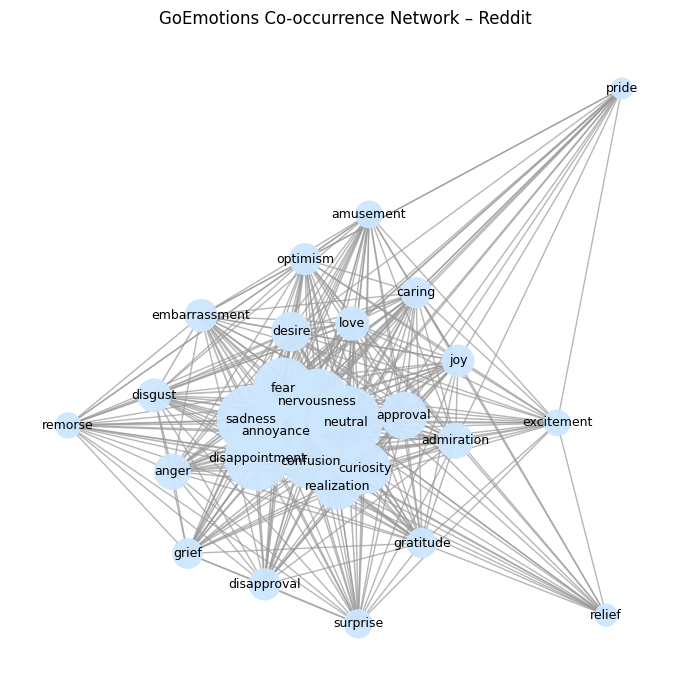

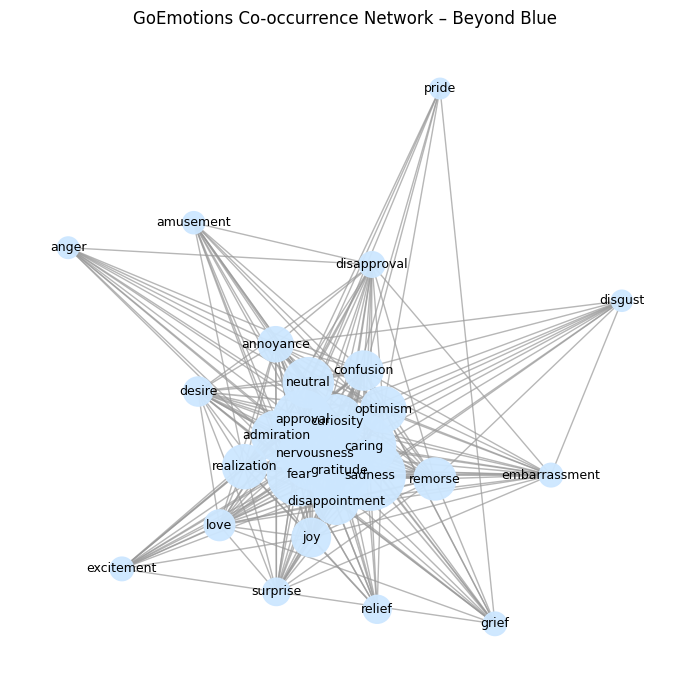

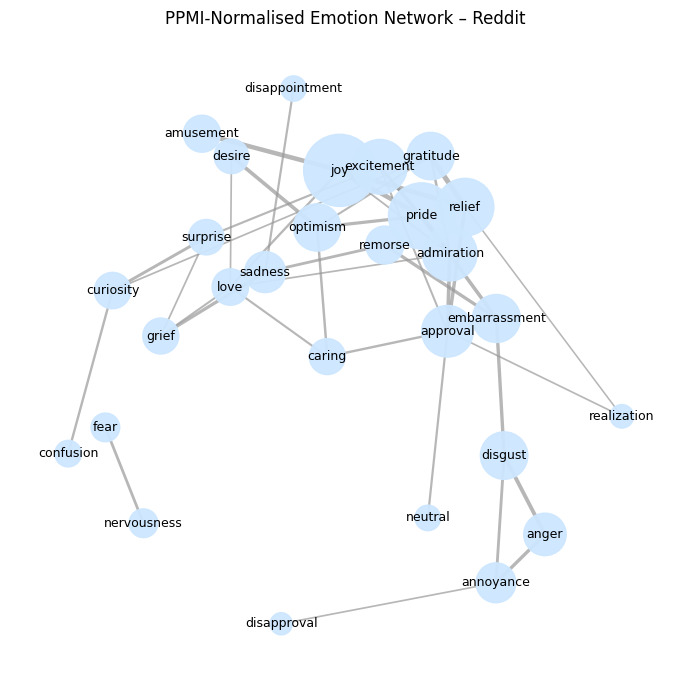

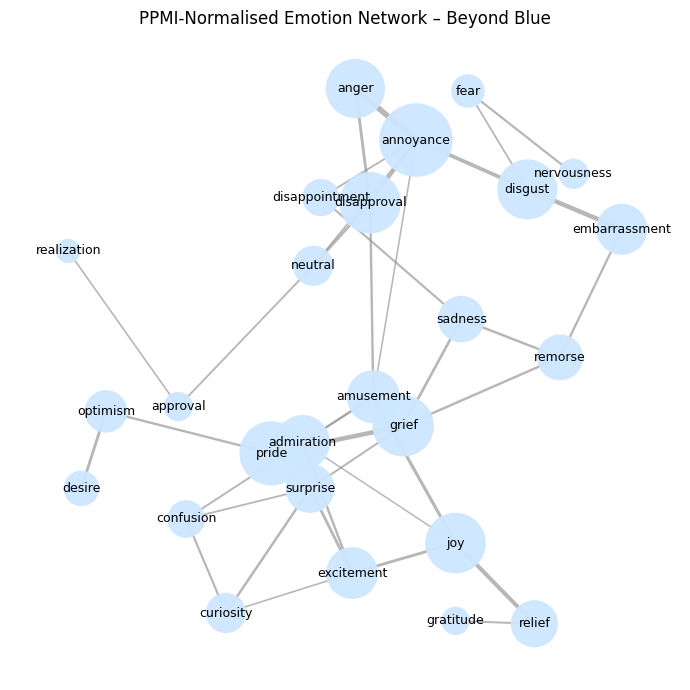

In [60]:
import matplotlib.pyplot as plt

def plot_network(G, title):
    plt.figure(figsize=(7,7))
    pos = nx.spring_layout(G, k=0.7, seed=42)

    degrees = dict(G.degree(weight="weight"))
    sizes = [200 + 2500*(degrees[n]/max(degrees.values())) for n in G.nodes()]
    widths = [1 + 3*(G[u][v]["weight"]/max(nx.get_edge_attributes(G,"weight").values()))
              for u,v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="#CDE7FF", alpha=0.95)
    nx.draw_networkx_edges(G, pos, width=widths, alpha=0.7, edge_color="#999999")
    nx.draw_networkx_labels(G, pos, font_size=9)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_network(G_reddit, "GoEmotions Co-occurrence Network – Reddit")
plot_network(G_bb, "GoEmotions Co-occurrence Network – Beyond Blue")

plot_network(G_reddit_ppmi, "PPMI-Normalised Emotion Network – Reddit")
plot_network(G_bb_ppmi, "PPMI-Normalised Emotion Network – Beyond Blue")


In [61]:
summary = pd.concat([
    reddit_cent.assign(type="raw").head(5),
    bb_cent.assign(type="raw").head(5),
    reddit_ppmi_thr.assign(type="ppmi").head(5),
    bb_ppmi_thr.assign(type="ppmi").head(5),
], ignore_index=True)

summary.to_csv("network_summary.csv", index=False)
summary.head()


platform         emotion  degree  betweenness  eigenvector type source  \
0   reddit     nervousness     1.0          0.0     0.409355  raw    NaN   
1   reddit         sadness     1.0          0.0     0.398335  raw    NaN   
2   reddit  disappointment     1.0          0.0     0.368289  raw    NaN   
3   reddit         neutral     1.0          0.0     0.364308  raw    NaN   
4   reddit            fear     1.0          0.0     0.364271  raw    NaN   

  target  ppmi  
0    NaN   NaN  
1    NaN   NaN  
2    NaN   NaN  
3    NaN   NaN  
4    NaN   NaN

In [62]:
reddit_ppmi["ppmi"].describe()


count    352.000000
mean       0.120228
std        0.401109
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.765067
Name: ppmi, dtype: float64

In [63]:
q = reddit_ppmi["ppmi"].quantile(0.75)  # top 25% strongest links
reddit_ppmi_thr = reddit_ppmi[reddit_ppmi["ppmi"] >= q].copy()

q_bb = bb_ppmi["ppmi"].quantile(0.75)
bb_ppmi_thr = bb_ppmi[bb_ppmi["ppmi"] >= q_bb].copy()

print(len(reddit_ppmi), "→", len(reddit_ppmi_thr), "edges after threshold")
print(len(bb_ppmi), "→", len(bb_ppmi_thr), "edges after threshold")


352 → 352 edges after threshold
291 → 291 edges after threshold


In [64]:
reddit_ppmi_top = reddit_ppmi.sort_values("ppmi", ascending=False).head(30)
bb_ppmi_top     = bb_ppmi.sort_values("ppmi", ascending=False).head(30)


In [65]:
def build_graph_ppmi(ppmi_df):
    G = nx.Graph()
    for _, r in ppmi_df.iterrows():
        G.add_edge(r["source"], r["target"], weight=r["ppmi"])
    return G

G_reddit_ppmi = build_graph_ppmi(reddit_ppmi_top)   # or reddit_ppmi_thr
G_bb_ppmi     = build_graph_ppmi(bb_ppmi_top)       # or bb_ppmi_thr


In [67]:
import networkx as nx
import pandas as pd

# If G_reddit / G_bb are not already defined, rebuild them from reddit_edges / bb_edges:
def build_graph(edges_df):
    G = nx.Graph()
    for _, r in edges_df.iterrows():
        G.add_edge(r["source"], r["target"], weight=r["weight"])
    return G

# comment these out if you already have G_reddit, G_bb
G_reddit = build_graph(reddit_edges)
G_bb     = build_graph(bb_edges)

def get_centrality_df(G, platform_name):
    deg = nx.degree_centrality(G)
    eig = nx.eigenvector_centrality_numpy(G, weight="weight")

    rows = []
    for node in G.nodes():
        rows.append({
            "platform": platform_name,
            "emotion": node,
            "degree_centrality": deg.get(node, 0.0),
            "eigenvector_centrality": eig.get(node, 0.0),
        })
    df_cent = pd.DataFrame(rows)
    # sort by eigenvector importance
    df_cent = df_cent.sort_values("eigenvector_centrality", ascending=False)
    return df_cent

reddit_cent = get_centrality_df(G_reddit, "reddit")
bb_cent     = get_centrality_df(G_bb, "beyondblue")

print(reddit_cent.head())
print(bb_cent.head())


   platform         emotion  degree_centrality  eigenvector_centrality
1    reddit     nervousness                1.0                0.409355
2    reddit         sadness                1.0                0.398335
0    reddit  disappointment                1.0                0.368289
11   reddit         neutral                1.0                0.364308
12   reddit            fear                1.0                0.364271
      platform      emotion  degree_centrality  eigenvector_centrality
2   beyondblue  nervousness           0.888889                0.457647
1   beyondblue         fear           0.962963                0.388929
14  beyondblue      sadness           0.962963                0.377052
11  beyondblue    gratitude           1.000000                0.341774
0   beyondblue       caring           0.888889                0.330334


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/2075249355.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/2075249355.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


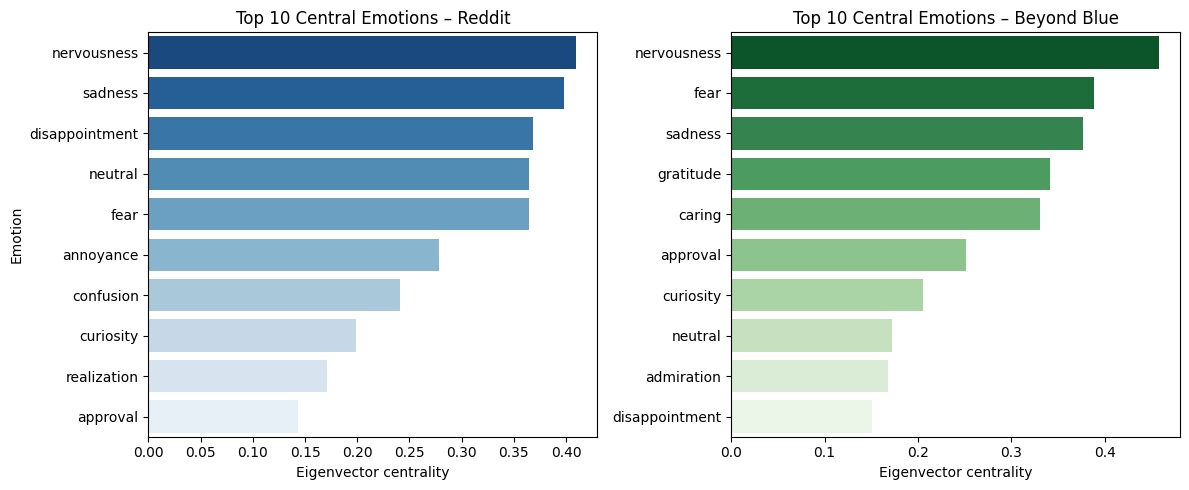

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# pick top 10 by eigenvector centrality
top_k = 10
reddit_top10 = reddit_cent.head(top_k).copy()
bb_top10     = bb_cent.head(top_k).copy()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(
    data=reddit_top10,
    x="eigenvector_centrality",
    y="emotion",
    palette="Blues_r"
)
plt.title("Top 10 Central Emotions – Reddit")
plt.xlabel("Eigenvector centrality")
plt.ylabel("Emotion")

plt.subplot(1,2,2)
sns.barplot(
    data=bb_top10,
    x="eigenvector_centrality",
    y="emotion",
    palette="Greens_r"
)
plt.title("Top 10 Central Emotions – Beyond Blue")
plt.xlabel("Eigenvector centrality")
plt.ylabel("")

plt.tight_layout()
plt.show()


In [69]:
import numpy as np

def compute_ppmi(edges_df):
    """
    edges_df: columns [source, target, weight]
    Returns: ppmi_df with [source, target, ppmi]
    """
    if edges_df.empty:
        return pd.DataFrame(columns=["source","target","ppmi"])

    # total co-occurrences
    total = edges_df["weight"].sum()

    # marginal counts
    marg = {}
    for _, row in edges_df.iterrows():
        a, b, w = row["source"], row["target"], row["weight"]
        marg[a] = marg.get(a, 0) + w
        marg[b] = marg.get(b, 0) + w

    rows = []
    for _, row in edges_df.iterrows():
        a, b, w = row["source"], row["target"], row["weight"]
        p_ab = w / total
        p_a  = marg[a] / total
        p_b  = marg[b] / total
        pmi  = np.log2(p_ab / (p_a * p_b)) if p_ab > 0 else 0
        ppmi = max(pmi, 0)
        rows.append({"source": a, "target": b, "ppmi": ppmi})

    return pd.DataFrame(rows)

reddit_ppmi = compute_ppmi(reddit_edges)
bb_ppmi     = compute_ppmi(bb_edges)

print("Reddit PPMI:\n", reddit_ppmi.head())
print("BB PPMI:\n", bb_ppmi.head())


Reddit PPMI:
            source       target     ppmi
0  disappointment  nervousness  0.00000
1  disappointment      sadness  0.53755
2     nervousness      sadness  0.00000
3       annoyance         love  0.00000
4       annoyance      sadness  0.00000
BB PPMI:
         source       target      ppmi
0       caring         fear  0.000000
1       caring  nervousness  0.000000
2         fear  nervousness  0.703111
3       caring     optimism  0.000000
4  nervousness     optimism  0.000000


In [70]:
reddit_ppmi_thr = reddit_ppmi[reddit_ppmi["ppmi"] > 0.0].copy()
bb_ppmi_thr     = bb_ppmi[bb_ppmi["ppmi"] > 0.0].copy()


In [72]:
import networkx as nx

def build_graph_from_edges(edges_df):
    G = nx.Graph()
    for _, row in edges_df.iterrows():
        G.add_edge(row["source"], row["target"], weight=row["weight"])
    return G

G_reddit = build_graph_from_edges(reddit_edges)
G_bb     = build_graph_from_edges(bb_edges)

print("Reddit nodes:", G_reddit.number_of_nodes(), "edges:", G_reddit.number_of_edges())
print("BB nodes:", G_bb.number_of_nodes(), "edges:", G_bb.number_of_edges())


Reddit nodes: 28 edges: 352
BB nodes: 28 edges: 291


In [74]:
def centrality_table(G, platform_name, top_k=10):
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, weight="weight", normalized=True)
    eig = nx.eigenvector_centrality_numpy(G, weight="weight")

    rows = []
    for node in G.nodes():
        rows.append({
            "platform": platform_name,
            "emotion": node,
            "degree_centrality": deg.get(node, 0.0),
            "betweenness_centrality": bet.get(node, 0.0),
            "eigenvector_centrality": eig.get(node, 0.0),
        })

    df_cent = pd.DataFrame(rows)
    # sort by eigenvector centrality as a proxy for global importance
    df_cent = df_cent.sort_values("eigenvector_centrality", ascending=False).head(top_k)
    return df_cent

reddit_cent = centrality_table(G_reddit, "reddit", top_k=10)
bb_cent     = centrality_table(G_bb, "beyondblue", top_k=10)

print("Reddit centrality:\n", reddit_cent)
print("Beyond Blue centrality:\n", bb_cent)


Reddit centrality:
    platform         emotion  degree_centrality  betweenness_centrality  \
1    reddit     nervousness           1.000000                0.000000   
2    reddit         sadness           1.000000                0.000000   
0    reddit  disappointment           1.000000                0.000000   
11   reddit         neutral           1.000000                0.000000   
12   reddit            fear           1.000000                0.000000   
3    reddit       annoyance           1.000000                0.000000   
5    reddit       confusion           1.000000                0.027066   
6    reddit       curiosity           0.962963                0.000000   
10   reddit     realization           1.000000                0.000000   
9    reddit        approval           1.000000                0.038462   

    eigenvector_centrality  
1                 0.409355  
2                 0.398335  
0                 0.368289  
11                0.364308  
12                0.

In [76]:
def largest_component(G):
    comps = list(nx.connected_components(G))
    largest = max(comps, key=len)
    return G.subgraph(largest).copy()

G_reddit_lcc = largest_component(G_reddit)
G_bb_lcc     = largest_component(G_bb)


In [77]:
def get_centrality_df(G, platform_name):
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, weight="weight")
    eig = nx.eigenvector_centrality(G, weight="weight", max_iter=2000, tol=1e-06)

    rows = []
    for node in G.nodes():
        rows.append({
            "platform": platform_name,
            "emotion": node,
            "degree_centrality": deg[node],
            "betweenness_centrality": bet[node],
            "eigenvector_centrality": eig[node],
        })
    return pd.DataFrame(rows).sort_values("eigenvector_centrality", ascending=False)

reddit_cent = get_centrality_df(G_reddit_lcc, "reddit")
bb_cent     = get_centrality_df(G_bb_lcc, "beyondblue")

reddit_cent.head(), bb_cent.head()


(   platform         emotion  degree_centrality  betweenness_centrality  \
 1    reddit     nervousness                1.0                     0.0   
 2    reddit         sadness                1.0                     0.0   
 0    reddit  disappointment                1.0                     0.0   
 11   reddit         neutral                1.0                     0.0   
 12   reddit            fear                1.0                     0.0   
 
     eigenvector_centrality  
 1                 0.409354  
 2                 0.398334  
 0                 0.368290  
 11                0.364308  
 12                0.364272  ,
       platform      emotion  degree_centrality  betweenness_centrality  \
 2   beyondblue  nervousness           0.888889                0.019943   
 1   beyondblue         fear           0.962963                0.000000   
 14  beyondblue      sadness           0.962963                0.002849   
 11  beyondblue    gratitude           1.000000                0.00

In [78]:
def largest_component(G):
    comps = list(nx.connected_components(G))
    largest = max(comps, key=len)
    return G.subgraph(largest).copy()

G_reddit_lcc = largest_component(G_reddit)
G_bb_lcc     = largest_component(G_bb)


In [79]:
def get_centrality_df(G, platform_name):
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, weight="weight")
    eig = nx.eigenvector_centrality(G, weight="weight", max_iter=2000, tol=1e-06)

    rows = []
    for node in G.nodes():
        rows.append({
            "platform": platform_name,
            "emotion": node,
            "degree_centrality": deg[node],
            "betweenness_centrality": bet[node],
            "eigenvector_centrality": eig[node],
        })
    return pd.DataFrame(rows).sort_values("eigenvector_centrality", ascending=False)

reddit_cent = get_centrality_df(G_reddit_lcc, "reddit")
bb_cent     = get_centrality_df(G_bb_lcc, "beyondblue")

reddit_cent.head(), bb_cent.head()


(   platform         emotion  degree_centrality  betweenness_centrality  \
 1    reddit     nervousness                1.0                     0.0   
 2    reddit         sadness                1.0                     0.0   
 0    reddit  disappointment                1.0                     0.0   
 11   reddit         neutral                1.0                     0.0   
 12   reddit            fear                1.0                     0.0   
 
     eigenvector_centrality  
 1                 0.409354  
 2                 0.398334  
 0                 0.368290  
 11                0.364308  
 12                0.364272  ,
       platform      emotion  degree_centrality  betweenness_centrality  \
 2   beyondblue  nervousness           0.888889                0.019943   
 1   beyondblue         fear           0.962963                0.000000   
 14  beyondblue      sadness           0.962963                0.002849   
 11  beyondblue    gratitude           1.000000                0.00

In [81]:
import networkx as nx
import pandas as pd

def network_stats(G, platform):
    return {
        "platform": platform,
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "avg_clustering": nx.average_clustering(G, weight="weight"),
    }

stats_reddit = network_stats(G_reddit, "reddit")
stats_bb     = network_stats(G_bb, "beyondblue")

stats_df = pd.DataFrame([stats_reddit, stats_bb])
print(stats_df)


     platform  nodes  edges  avg_degree   density  avg_clustering
0      reddit     28    352   25.142857  0.931217        0.027081
1  beyondblue     28    291   20.785714  0.769841        0.031371


In [82]:
from networkx.algorithms.community import greedy_modularity_communities

def detect_communities(G):
    communities = list(greedy_modularity_communities(G))
    # Create dict: node -> community ID
    node2com = {}
    for i, com in enumerate(communities):
        for node in com:
            node2com[node] = i
    return node2com, communities

reddit_com_map, reddit_comms = detect_communities(G_reddit)
bb_com_map, bb_comms = detect_communities(G_bb)

print("Reddit communities:", len(reddit_comms))
print("BB communities:", len(bb_comms))


Reddit communities: 2
BB communities: 3


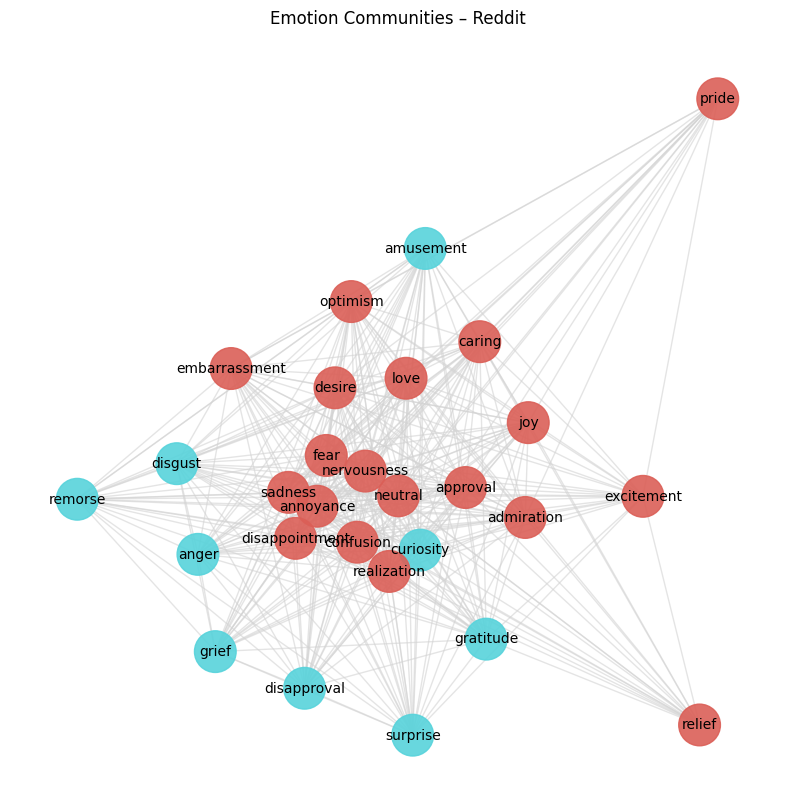

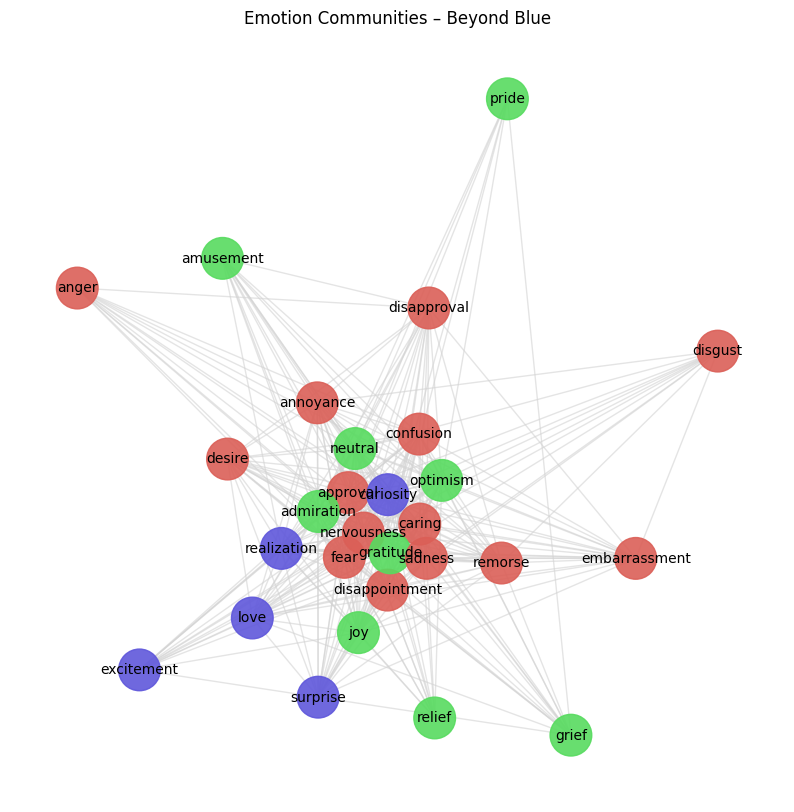

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_community_graph(G, node2com, title):
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G, seed=42, k=0.7)

    # Assign colors per community
    communities = sorted(set(node2com.values()))
    palette = sns.color_palette("hls", len(communities))
    color_map = {c: palette[i] for i, c in enumerate(communities)}

    node_colors = [color_map[node2com[n]] for n in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.9, node_size=900)
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(title)
    plt.axis("off")
    plt.show()

plot_community_graph(G_reddit, reddit_com_map, "Emotion Communities – Reddit")
plot_community_graph(G_bb, bb_com_map, "Emotion Communities – Beyond Blue")


In [84]:
def sadness_neighbors(edges_df):
    sad_edges = edges_df[
        (edges_df["source"]=="sadness") | (edges_df["target"]=="sadness")
    ].copy()

    sad_edges["other"] = sad_edges.apply(
        lambda r: r["target"] if r["source"]=="sadness" else r["source"], axis=1
    )

    return sad_edges.sort_values("weight", ascending=False)

reddit_sad = sadness_neighbors(reddit_edges).head(5)
bb_sad = sadness_neighbors(bb_edges).head(5)

print("Reddit sadness neighbors:\n", reddit_sad)
print("\nBeyondBlue sadness neighbors:\n", bb_sad)


Reddit sadness neighbors:
             source   target  weight           other
1   disappointment  sadness    6979  disappointment
2      nervousness  sadness    3607     nervousness
18            fear  sadness    3099            fear
4        annoyance  sadness    1766       annoyance
16         neutral  sadness    1730         neutral

BeyondBlue sadness neighbors:
             source   target  weight           other
27          caring  sadness     978          caring
41  disappointment  sadness     930  disappointment
36     nervousness  sadness     928     nervousness
73         remorse  sadness     925         remorse
28       gratitude  sadness     869       gratitude


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/2848867463.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reddit_sad, x="weight", y="other", palette="Blues_r")
/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/2848867463.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bb_sad, x="weight", y="other", palette="Greens_r")


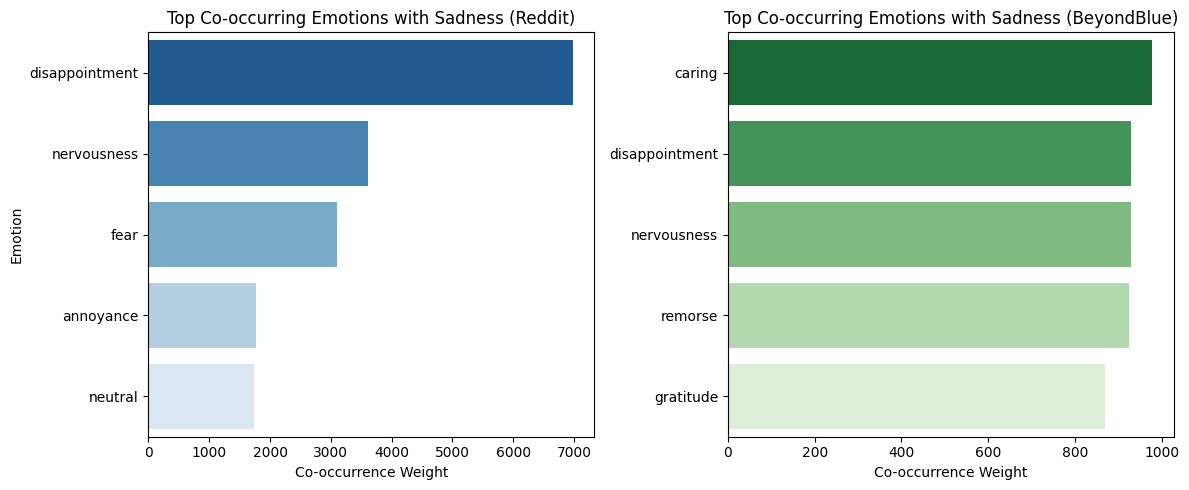

In [85]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(data=reddit_sad, x="weight", y="other", palette="Blues_r")
plt.title("Top Co-occurring Emotions with Sadness (Reddit)")
plt.xlabel("Co-occurrence Weight")
plt.ylabel("Emotion")

plt.subplot(1,2,2)
sns.barplot(data=bb_sad, x="weight", y="other", palette="Greens_r")
plt.title("Top Co-occurring Emotions with Sadness (BeyondBlue)")
plt.xlabel("Co-occurrence Weight")
plt.ylabel("")

plt.tight_layout()
plt.show()


In [86]:
reddit_rank = reddit_cent[["emotion","eigenvector_centrality"]].reset_index(drop=True)
bb_rank     = bb_cent[["emotion","eigenvector_centrality"]].reset_index(drop=True)

reddit_rank["reddit_rank"] = reddit_rank.index + 1
bb_rank["bb_rank"] = bb_rank.index + 1

merged = pd.merge(reddit_rank, bb_rank, on="emotion", how="inner")
merged = merged[["emotion","reddit_rank","bb_rank"]].sort_values("reddit_rank")

print(merged.head(15))


           emotion  reddit_rank  bb_rank
0      nervousness            1        1
1          sadness            2        3
2   disappointment            3       10
3          neutral            4        8
4             fear            5        2
5        annoyance            6       16
6        confusion            7       14
7        curiosity            8        7
8      realization            9       12
9         approval           10        6
10          desire           11       18
11           anger           12       27
12      admiration           13        9
13         disgust           14       26
14   embarrassment           15       23


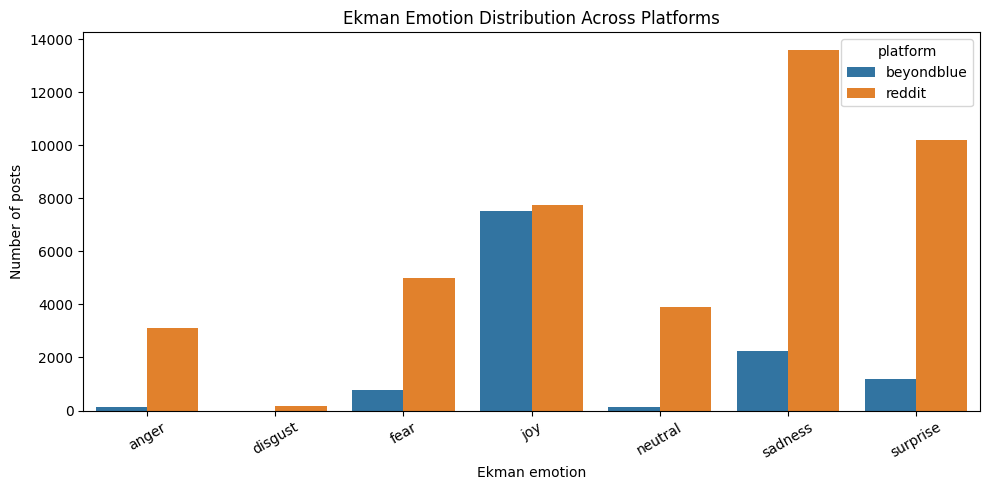

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Try to auto-detect the Ekman label column
ekman_col = next(c for c in df_ek.columns if "ekman" in c.lower())

ek_counts = (
    df_ek.groupby(["platform", ekman_col])
         .size()
         .reset_index(name="count")
)

plt.figure(figsize=(10,5))
sns.barplot(
    data=ek_counts,
    x=ekman_col,
    y="count",
    hue="platform"
)
plt.xticks(rotation=30)
plt.ylabel("Number of posts")
plt.xlabel("Ekman emotion")
plt.title("Ekman Emotion Distribution Across Platforms")
plt.tight_layout()
plt.show()


In [90]:
df_ek = pd.concat([reddit_ek, bb_ek], ignore_index=True)

In [94]:
import pandas as pd

reddit_ek3 = pd.read_csv("emotion_output_ekman_predicted_top3.csv")


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/3631270890.py:3: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_ek3 = pd.read_csv("emotion_output_ekman_predicted_top3.csv")


In [95]:
def to_list_ekman(s):
    if pd.isna(s):
        return []
    return [e.strip() for e in str(s).split(",") if e.strip()]

reddit_ek3["ekman_list"] = reddit_ek3["top_3_ekman"].apply(to_list_ekman)

reddit_ek3[["top_3_ekman", "ekman_list"]].head()




top_3_ekman                 ekman_list
0   sadness, fear, neutral   [sadness, fear, neutral]
1  sadness, anger, neutral  [sadness, anger, neutral]
2  surprise, sadness, fear  [surprise, sadness, fear]
3     anger, fear, sadness     [anger, fear, sadness]
4   sadness, fear, neutral   [sadness, fear, neutral]

In [96]:
import itertools
from collections import Counter

def build_ekman_edges(frame, list_col, min_weight=2):
    pair_counts = Counter()

    for emos in frame[list_col]:
        if not isinstance(emos, (list, tuple)):
            continue
        uniques = sorted(set(emos))
        if len(uniques) < 2:
            continue

        for a, b in itertools.combinations(uniques, 2):
            pair_counts[(a, b)] += 1

    rows = [
        {"source": a, "target": b, "weight": w}
        for (a, b), w in pair_counts.items()
        if w >= min_weight
    ]
    return pd.DataFrame(rows)

reddit_ek_edges = build_ekman_edges(reddit_ek3, "ekman_list", min_weight=2)
reddit_ek_edges.head()


source   target  weight
0     fear  neutral   18427
1     fear  sadness   19329
2  neutral  sadness   21557
3    anger  neutral    5952
4    anger  sadness    6468

In [97]:
import networkx as nx

def build_graph(edges_df):
    G = nx.Graph()
    for _, r in edges_df.iterrows():
        G.add_edge(r["source"], r["target"], weight=r["weight"])
    return G

G_reddit_ek = build_graph(reddit_ek_edges)

print("Nodes:", G_reddit_ek.number_of_nodes(), 
      "Edges:", G_reddit_ek.number_of_edges())


Nodes: 7 Edges: 21


In [98]:
def centrality_ekman(G):
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G, weight="weight")
    eig = nx.eigenvector_centrality(G, weight="weight")

    rows = []
    for n in G.nodes():
        rows.append({
            "emotion": n,
            "degree_centrality": deg[n],
            "betweenness_centrality": bet[n],
            "eigenvector_centrality": eig[n],
        })
    return pd.DataFrame(rows).sort_values("eigenvector_centrality", ascending=False)

reddit_ek_cent = centrality_ekman(G_reddit_ek)
reddit_ek_cent


emotion  degree_centrality  betweenness_centrality  eigenvector_centrality
1   neutral                1.0                0.000000                0.555622
2   sadness                1.0                0.000000                0.540506
0      fear                1.0                0.000000                0.492268
6   disgust                1.0                0.133333                0.224915
3     anger                1.0                0.266667                0.211934
5       joy                1.0                0.000000                0.196136
4  surprise                1.0                0.600000                0.151124

In [102]:
stats_df


platform  nodes  edges  avg_degree   density  avg_clustering
0      reddit     28    352   25.142857  0.931217        0.027081
1  beyondblue     28    291   20.785714  0.769841        0.031371

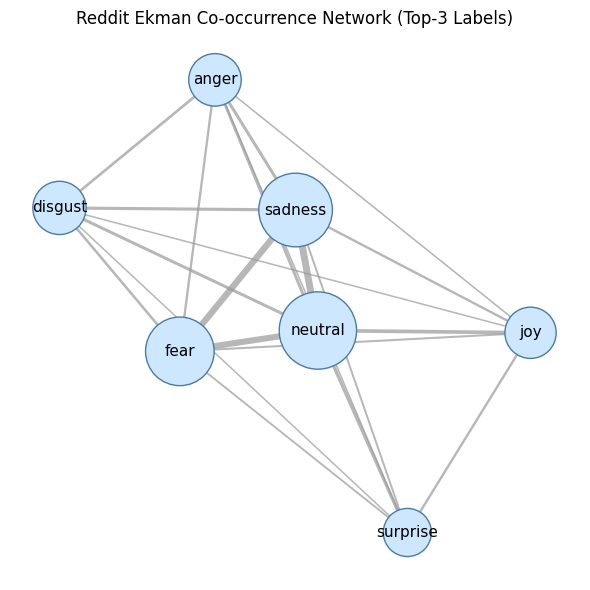

In [99]:
import matplotlib.pyplot as plt

def plot_ekman_network(G, title):
    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42, k=0.7)

    deg = dict(G.degree(weight="weight"))
    max_deg = max(deg.values()) if deg else 1
    sizes = [600 + 2500*(deg[n]/max_deg) for n in G.nodes()]

    weights = nx.get_edge_attributes(G, "weight")
    max_w = max(weights.values()) if weights else 1
    widths = [1 + 4*(w/max_w) for w in weights.values()]

    nx.draw_networkx_nodes(G, pos, node_color="#CDE7FF", node_size=sizes, edgecolors="#4A7BA6")
    nx.draw_networkx_edges(G, pos, width=widths, edge_color="#999999", alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=11)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_ekman_network(G_reddit_ek, "Reddit Ekman Co-occurrence Network (Top-3 Labels)")


In [100]:
def sadness_neighbors(edges_df):
    sad = edges_df[
        (edges_df["source"]=="sadness") | (edges_df["target"]=="sadness")
    ].copy()

    sad["other"] = sad.apply(lambda r:
                             r["target"] if r["source"]=="sadness" else r["source"],
                             axis=1)
    return sad.sort_values("weight", ascending=False)

reddit_ek_sad = sadness_neighbors(reddit_ek_edges)
reddit_ek_sad


source    target  weight     other
2   neutral   sadness   21557   neutral
1      fear   sadness   19329      fear
11  disgust   sadness    6792   disgust
4     anger   sadness    6468     anger
9       joy   sadness    3992       joy
6   sadness  surprise    2208  surprise

/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/3311692928.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reddit_ek_sad, x="weight", y="other", palette="Blues_r")


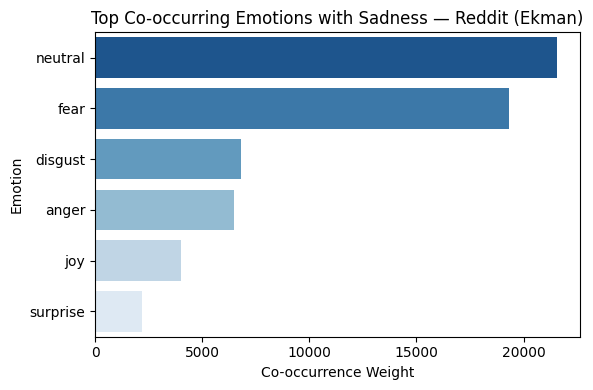

In [101]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(data=reddit_ek_sad, x="weight", y="other", palette="Blues_r")
plt.title("Top Co-occurring Emotions with Sadness — Reddit (Ekman)")
plt.xlabel("Co-occurrence Weight")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()


Saved: fig_goemotions_networks_sidebyside.png


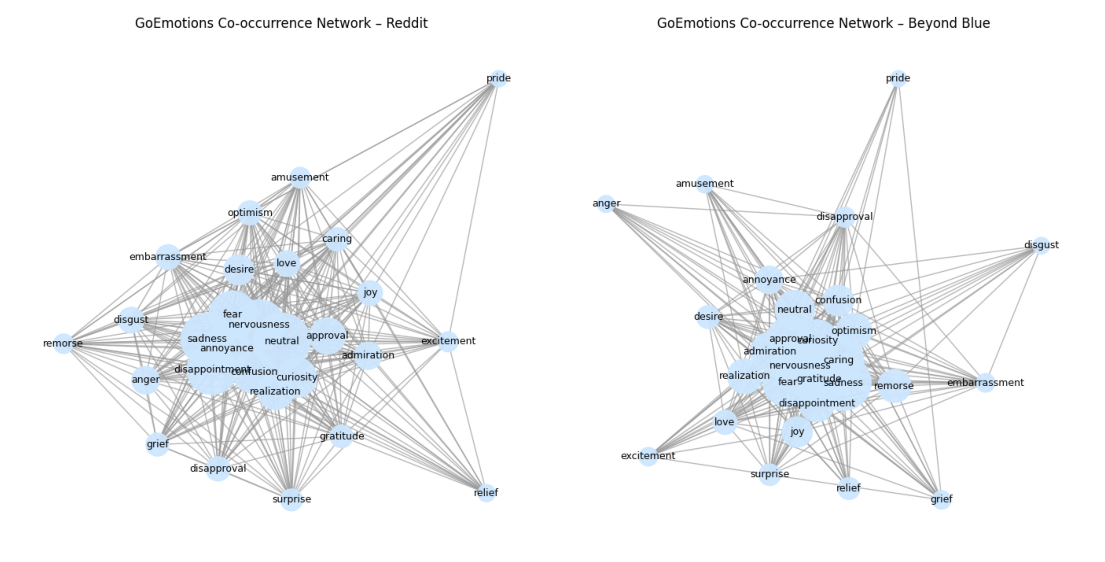

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_reddit = Image.open("go_e_reddit.png")
img_bb = Image.open("go_emo_bb.png")

# Ensure same height for clean alignment
h = max(img_reddit.height, img_bb.height)
img_reddit = img_reddit.resize((img_reddit.width, h))
img_bb = img_bb.resize((img_bb.width, h))

# Create a combined canvas
combined_width = img_reddit.width + img_bb.width
combined = Image.new("RGB", (combined_width, h), color="white")

# Paste both images
combined.paste(img_reddit, (0, 0))
combined.paste(img_bb, (img_reddit.width, 0))

# Save output
output_name = "fig_goemotions_networks_sidebyside.png"
combined.save(output_name, quality=95)

print("Saved:", output_name)

# Display in notebook
plt.figure(figsize=(14,8))
plt.imshow(combined)
plt.axis("off")
plt.show()


In [108]:
df = pd.read_csv("emotion_output_ekman_predicted_top3.csv")

df["emo_list"] = df["top_3_ekman"].apply(lambda x: [t.strip() for t in str(x).split(",")])
df["primary_ekman"] = df["emo_list"].apply(lambda x: x[0] if len(x)>0 else None)

ekman_classes = ["anger","disgust","fear","joy","neutral","sadness","surprise"]


/var/folders/xr/wnl4swlj3hl1vcftpb0gnzb80000gn/T/ipykernel_2780/3452609279.py:1: DtypeWarning: Columns (7,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("emotion_output_ekman_predicted_top3.csv")


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_words_for_emotion(emotion, k=20):
    subset = df[df["primary_ekman"] == emotion]["clean_text"].astype(str)
    if subset.empty:
        return []
    
    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_features=5000
    )
    X = vectorizer.fit_transform(subset)
    scores = X.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()

    top_idx = scores.argsort()[::-1][:k]
    return list(words[top_idx])

emotion_vocab = {
    emo: get_top_words_for_emotion(emo, k=20)
    for emo in ekman_classes
}

emotion_vocab


{'anger': ['just',
  'hate',
  'like',
  'don',
  'fucking',
  'people',
  'want',
  'feel',
  'fuck',
  'know',
  'life',
  'im',
  've',
  'really',
  'shit',
  'time',
  'think',
  'going',
  'help',
  'angry'],
 'disgust': ['like',
  'just',
  'feel',
  'don',
  'people',
  'know',
  'want',
  've',
  'really',
  'think',
  'bad',
  'weird',
  'time',
  'hate',
  'im',
  'life',
  'worse',
  'things',
  'way',
  'got'],
 'fear': ['like',
  'just',
  'feel',
  'don',
  'anxiety',
  'know',
  've',
  'want',
  'people',
  'really',
  'im',
  'time',
  'life',
  'scared',
  'help',
  'going',
  'think',
  'things',
  'years',
  'feeling'],
 'joy': ['like',
  'just',
  'happy',
  'feel',
  'don',
  'time',
  'know',
  've',
  'people',
  'sunday',
  'life',
  'really',
  'want',
  'good',
  'love',
  'selfie',
  'day',
  'got',
  'im',
  'friends'],
 'neutral': ['nan',
  'like',
  'just',
  'don',
  'feel',
  'people',
  'know',
  've',
  'time',
  'want',
  'anxiety',
  'think',
  'bu

In [110]:
import numpy as np
import networkx as nx
import itertools
from collections import Counter

def build_ppmi_network(emotion, vocab):
    posts = df[df["primary_ekman"] == emotion]["clean_text"].astype(str)

    # count pair occurrences
    pair_counts = Counter()
    word_counts = Counter()
    total_posts = len(posts)

    for text in posts:
        toks = [w for w in text.lower().split() if w in vocab]
        unique = set(toks)
        for w in unique:
            word_counts[w] += 1
        for w1, w2 in itertools.combinations(unique, 2):
            pair_counts[tuple(sorted((w1,w2)))] += 1
    
    G = nx.Graph()
    G.add_nodes_from(vocab)

    for (w1,w2), c_xy in pair_counts.items():
        p_xy = c_xy / total_posts
        p_x = word_counts[w1] / total_posts
        p_y = word_counts[w2] / total_posts

        ppmi = max(np.log2(p_xy / (p_x * p_y)), 0)
        if ppmi > 0.05:
            G.add_edge(w1, w2, weight=ppmi)
    return G


In [117]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    doc = nlp(text.lower())
    tokens = []

    for t in doc:
        # keep only meaningful lexicon
        if (
            t.is_alpha and
            not t.is_stop and
            len(t.lemma_) > 3 and
            t.pos_ in ["NOUN", "VERB", "ADJ", "ADV"]
        ):
            tokens.append(t.lemma_)
    return tokens


In [118]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    doc = nlp(text.lower())
    tokens = []

    for t in doc:
        # keep only meaningful lexicon
        if (
            t.is_alpha and
            not t.is_stop and
            len(t.lemma_) > 3 and
            t.pos_ in ["NOUN", "VERB", "ADJ", "ADV"]
        ):
            tokens.append(t.lemma_)
    return tokens


In [119]:
import itertools
from collections import Counter

def word_edges(word_lists, top_words, min_count=5):
    counter = Counter()
    for words in word_lists:
        filtered = [w for w in words if w in top_words]
        for a, b in itertools.combinations(sorted(set(filtered)), 2):
            counter[(a, b)] += 1

    edges = [(a, b, w) for (a, b), w in counter.items() if w >= min_count]
    return edges


In [120]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_word_network(emotion, edges):
    G = nx.Graph()
    for a, b, w in edges:
        G.add_edge(a, b, weight=w)

    pos = nx.spring_layout(G, k=1)

    plt.figure(figsize=(7,7))
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#b3d1ff")
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*0.1 for u,v in G.edges()],
                           alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(f"{emotion.capitalize()} — Psychologically Meaningful Word Network")
    plt.axis("off")
    plt.show()
